In [2]:
import os
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.ticker as tck
from matplotlib import colors

import numpy as np

from scipy.interpolate import interp1d

import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.constants as const

from astropy.cosmology import default_cosmology
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from astropy.io import fits
from astropy import constants as const
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
from astropy.constants import G, c, M_sun
import astropy.io.fits as pyfits
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Util import kernel_util
import emcee
import corner
import dynesty
from dynesty import utils as dyfunc
import pickle
from dynesty import plotting as dyplot
import matplotlib
import copy

mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
import pyswarms as ps
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
import warnings

warnings.filterwarnings('ignore')

import astropy.io.fits as pyfits
from astropy.io import fits
import matplotlib

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 55}
matplotlib.rc('font', **font)
warnings.filterwarnings('ignore')


matplotlib.rcParams['axes.linewidth'] = 5.0 #set the value globally

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
likemask = np.ones([70,70],dtype=bool)

for i in range(70):
    for j in range(70):
        if (i-32)**2. + (j-34)**2. < 30:
            likemask[i,j] = False
        if (i-34)**2. + (j-34)**2. > 1300:
            likemask[i,j] = False
            
ndeg = np.count_nonzero(likemask)

imagedata = np.load('sersic_source_subtracted.npy')

source_res = 4

observe_kwargs = {'read_noise': 4.0, 
                  'pixel_scale': 0.025, 
                  'ccd_gain': 2.5, 
                  'exposure_time': 6976., 
                  'sky_brightness': 22.3, 
                  'magnitude_zero_point': 25.96, 
                  'num_exposures': 1, 
                  'seeing': 0.07, 
                  'psf_type': 'PIXEL'}
hiresforsource = {'read_noise': 4.0, 
                  'pixel_scale': 0.025/source_res, 
                  'ccd_gain': 2.5, 
                  'exposure_time': 6976., 
                  'sky_brightness': 22.3, 
                  'magnitude_zero_point': 25.96, 
                  'num_exposures': 1, 
                  'seeing': 0.07, 
                  'psf_type': 'PIXEL'}

background_rms = 0.0042071166

exp_time = observe_kwargs['exposure_time']

z_interloper = 0.881
z_lens =  0.881
z_source =  2.059

numpix = 70
deltaPix = 0.025
ext = numpix*deltaPix/2.
extent = [-ext,ext,-ext,ext]

fwhm = 0.14
kernel_size = 91

kernel_point = np.zeros([91,91])
kernel_point[45,45] = 1.

kernel_cut = np.zeros([91,91])

for i in range(91):
    for j in range(91):
        sigm = (1./2.355)*(fwhm/deltaPix)
        kernel_cut[i,j] = np.exp(-(0.5/sigm**2.)*((i-45)**2. + (j-45)**2.))

kwargs_psf = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
kwargs_point = {'psf_type': 'PIXEL', 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_point}
psf_class = PSF(**kwargs_psf)
psf_point = PSF(**kwargs_point)

kwargs_numerics = {'point_source_supersampling_factor': 1}


#https://arxiv.org/pdf/1402.7073.pdf

def bfunc(z):
    return -0.101 + 0.026*z

def afunc(z):
    return 0.520 + (0.905 - 0.520)*np.exp(-0.617*(z**1.21))

def c200vsM200(M200,z):
    # This is in log10 units. Mass is h^-1 Msun
    return bfunc(z)*(M200-12) + afunc(z)

def nfw_from_M200(M200,z):
    # takes in logM200 in Msun
    # returns nfw params in arcsec
    lens_cosmo = LensCosmo(z_lens=z, z_source=z_source, cosmo=cosmo)
    Mh = M200 + np.log10(cosmo.h)
    concen = c200vsM200(Mh,z)
    
    Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=10**Mh, c=10**concen)
    
    return Rs_angle,alpha_Rs

def bestfit(result):
    #takes in the result, returns best fit and errors
    #and returns -logl
    logs = result.logl
    samps = result.samples
    argmax = np.argmax(logs)
    
    weights = np.exp(result.logwt - result.logz[-1])
    mean, cov = dyfunc.mean_and_cov(samps, weights)
    
    errs = [cov[i,i] for i in range(len(mean))]
    
    return logs[argmax],samps[argmax],np.sqrt(errs)*2.

def bic(logl,kparam):
    #takes in the logl and ndeg
    #and calculates the BIC
    return kparam*np.log(ndeg) - 2.*logl


def roundvalanderr(best,c0):
    #get best fit and cv and round
    logs = -np.log10(c0)
    rounded = np.zeros(len(best))
    roundederr = np.zeros(len(best))
    for i in range(len(best)):
        rounded[i] = round(best[i],1+int(round(logs[i])))
        roundederr[i] = round(c0[i],1+int(round(logs[i])))
    return rounded,roundederr

def printnice(best,c0):
    bestfround,cvround = roundvalanderr(best,c0)
    for i in range(len(bestfround)):
        print('%.3f + %.3f'% (best[i],c0[i]))
        
def getstats(reslist):
    ln = len(reslist)
    maxl = []
    bestf = []
    cv = []
    for i in range(ln):
        a,b,c = bestfit(reslist[i])
        maxl.append(a)
        bestf.append(b)
        cv.append(c)
    maxl = np.array(maxl)
    bestf = np.array(bestf)
    cv = np.array(cv)
    
    return maxl,bestf,cv 
        
def getbic(maxlist,nmodel):
    ln = len(maxlist)
    nmaxes = np.arange(ln) + 5
    
    bics = []
    
    for i in range(ln):
        kparam = (nmaxes[i]+1)*(nmaxes[i]+2)*0.5
        bicval = bic(maxlist[i],nmodel + kparam)
        bics.append(bicval)
    
    bics = np.array(bics)
    return bics  

def getbys(reslist):
    ln = len(reslist)
    bys = []
    for i in range(ln):
        by = np.max(reslist[i].logz)
        bys.append(by)
    bys = np.array(bys)
    return bys

def getplotc(samp,best):
    sampplot = copy.deepcopy(samp)
    bestplot = copy.deepcopy(best)

    sampplot.samples[:,9] = samp.samples[:,12]
    sampplot.samples[:,10] = samp.samples[:,9]
    sampplot.samples[:,11] = samp.samples[:,10]
    sampplot.samples[:,12] = samp.samples[:,11]

    bestplot[9] = best[12]
    bestplot[10] = best[9]
    bestplot[11] = best[10]
    bestplot[12] = best[11]
    
    return sampplot,bestplot
        
labls_mask = ['$\\theta_E$','$\\gamma$',  '$x_1$ [arcsec]', '$x_2$ [arcsec]','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
              '$\\delta$ [arcsec]','$x_s$ [arcsec]','$y_s$ [arcsec]']

labls_mask_sub = ['$\\theta_E$','$\\gamma$', '$x_1$ [arcsec]', '$x_2$ [arcsec]','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
                  '$b_\mathrm{int}$ [mas]','$x_\mathrm{int}$ [arcsec]','$y_\mathrm{int}$ [arcsec]',
                  '$\\delta$ [arcsec]','$x_s$ [arcsec]','$y_s$ [arcsec]']

labls_mask_sub_nfw = ['$\\theta_E$','$\\gamma$',  '$x_1$ [arcsec]', '$x_2$ [arcsec]','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
                      'm200','x_int','y_int',
                      '$\\delta$ [arcsec]','$x_s$ [arcsec]','$y_s$ [arcsec]']

labls_mask_sub_c = ['$\\theta_E$','$\\gamma$',  '$x_1$ [arcsec]', '$x_2$ [arcsec]','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
                    '$M_\mathrm{200}\, [10^{9}M_\odot]$','$x_\mathrm{int}$ [arcsec]','$y_\mathrm{int}$ [arcsec]','$c_{200}$',
                    '$\\delta$ [arcsec]','$x_s$ [arcsec]','$y_s$ [arcsec]']

labls_mask_sub_s = ['$\\theta_E$','$\\gamma$',  '$x_1$ [arcsec]', '$x_2$ [arcsec]','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
                    'theta_e','x_int','y_int','slope',
                     '$\\delta$ [arcsec]','$x_s$ [arcsec]','$y_s$ [arcsec]']

labls_mask_int = ['$\\theta_E$','$\\gamma$',  '$x_1$ [arcsec]', '$x_2$ [arcsec]','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
                  '$b_\mathrm{int}$ [mas]','$x_\mathrm{int}$ [arcsec]','$y_\mathrm{int}$ [arcsec]','$z_\mathrm{int}$',
                  '$\\delta$ [arcsec]','$x_s$ [arcsec]','$y_s$ [arcsec]']

labls_mask_int_nfw = ['$\\theta_E$','$\\gamma$',  '$x_1$ [arcsec]', '$x_2$ [arcsec]','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
                      '$M_\mathrm{200}\, [10^{9}M_\odot]$','$x_\mathrm{int}$ [arcsec]','$y_\mathrm{int}$ [arcsec]','$z_\mathrm{int}$',
                      '$\\delta$ [arcsec]','$x_s$ [arcsec]','$y_s$ [arcsec]']

labls_mask_int_c = ['$\\theta_E$','$\\gamma$',  '$x_1$ [arcsec]', '$x_2$ [arcsec]','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
                    '$M_\mathrm{200}\, [10^{9}M_\odot]$','$x_\mathrm{int}$ [arcsec]','$y_\mathrm{int}$ [arcsec]','$z_\mathrm{int}$','$c_{200}$',
                    '$\\delta$ [arcsec]','$x_s$ [arcsec]','$y_s$ [arcsec]']

labls_mask_int_s = ['$\\theta_E$','$\\gamma$',  '$x_1$ [arcsec]', '$x_2$ [arcsec]','$e_1$','$e_2$','$\\Gamma_1$','$\\Gamma_2$',
                    'theta_e','x_int','y_int','z_int','slope',
                    '$\\delta$ [arcsec]','$x_s$ [arcsec]','$y_s$ [arcsec]']


labls_mask_int_cplot = copy.deepcopy(labls_mask_int_c)
labls_mask_int_cplot[9] = labls_mask_int_c[12]
labls_mask_int_cplot[10] = labls_mask_int_c[9]
labls_mask_int_cplot[11] = labls_mask_int_c[10]
labls_mask_int_cplot[12] = labls_mask_int_c[11]

In [3]:
name0 = 'results/wideprior/mask3013_on_jvas_70pixSUBTR_n_max'
name1 = 'results/narrowprior/mask3013_NARROW_on_jvas_70pixSUBTR_n_max'
name2 = 'results/freeconcen/mask3013_NARROWCONCEN_on_jvas_70pixSUBTR_n_max'
name3 = 'results/freeconcen/oldprior/mask3013_NARROWCONCEN_on_jvas_70pixSUBTR_n_max'

sm = 'SMOOTH'
sb = 'SUB'
sbc = 'SUBc'
it = 'INT'
itc = 'INTc'

s = 'SIS'
j = 'PJAFFE'
n = 'NFW'

loadsmo = True
loadsub = True
loadsubj = True
loadsubn = True
loadint = True
loadintj = True
loadintn = True
loadsubc = True
loadintc = True

####################################################################################
if loadsmo:
    smo5 = load_obj(name0 + str(5) + sm + s)
    smo6 = load_obj(name0 + str(6) + sm + s)
    smo7 = load_obj(name0 + str(7) + sm + s)
    smo8 = load_obj(name0 + str(8) + sm + s)
    smo9 = load_obj(name0 + str(9) + sm + s)
    smo10 = load_obj(name1 + str(10) + sm + s)
    smo11 = load_obj(name1 + str(11) + sm + s)
    smo12 = load_obj(name1 + str(12) + sm + s)
    smo13 = load_obj(name1 + str(13) + sm + s)
    smo14 = load_obj(name1 + str(14) + sm + s)
    smo15 = load_obj(name1 + str(15) + sm + s)
    smo16 = load_obj(name1 + str(16) + sm + s)
    smo17 = load_obj(name1 + str(17) + sm + s)

    smos = [smo5,smo6,smo7,smo8,smo9,smo10,smo11,smo12,smo13,smo14,smo15,smo16,smo17]

    smomaxl, smobest, smocv = getstats(smos)
    bicsmo = getbic(smomaxl,11)
    bysmo = getbys(smos)

####################################################################################
if loadsub:
    sub5 = load_obj(name0 + str(5) + sb + s)
    sub6 = load_obj(name0 + str(6) + sb + s)
    sub7 = load_obj(name0 + str(7) + sb + s)
    sub8 = load_obj(name0 + str(8) + sb + s)
    sub9 = load_obj(name0 + str(9) + sb + s)
    sub10 = load_obj(name1 + str(10) + sb + s)
    sub11 = load_obj(name0 + str(11) + sb + s)
    sub12 = load_obj(name1 + str(12) + sb + s)
    sub13 = load_obj(name1 + str(13) + sb + s)
    sub14 = load_obj(name1 + str(14) + sb + s)
    sub15 = load_obj(name1 + str(15) + sb + s)
    sub16 = load_obj(name1 + str(16) + sb + s)
    sub17 = load_obj(name1 + str(17) + sb + s)

    subs = [sub5,sub6,sub7,sub8,sub9,sub10,sub11,sub12,sub13,sub14,sub15,sub16,sub17]

    submaxl, subbest, subcv = getstats(subs)
    bicsub = getbic(submaxl,14)
    bysub = getbys(subs)

####################################################################################
if loadsubj:
    subj5 = load_obj(name0 + str(5) + sb + j)
    subj6 = load_obj(name0 + str(6) + sb + j)
    subj7 = load_obj(name0 + str(7) + sb + j)
    subj8 = load_obj(name0 + str(8) + sb + j)
    subj9 = load_obj(name0 + str(9) + sb + j)
    subj10 = load_obj(name0 + str(10) + sb + j)
    subj11 = load_obj(name0 + str(11) + sb + j)
    subj12 = load_obj(name1 + str(12) + sb + j)
    subj13 = load_obj(name1 + str(13) + sb + j)
    subj14 = load_obj(name1 + str(14) + sb + j)
    subj15 = load_obj(name1 + str(15) + sb + j)
    subj16 = load_obj(name1 + str(16) + sb + j)
    subj17 = load_obj(name1 + str(17) + sb + j)

    subjs = [subj5,subj6,subj7,subj8,subj9,subj10,subj11,subj12,subj13,subj14,subj15,subj16,subj17]

    subjmaxl, subjbest, subjcv = getstats(subjs)
    bicsubj = getbic(subjmaxl,14)
    bysubj = getbys(subjs)

####################################################################################
if loadint:
    int5 = load_obj(name0 + str(5) + it + s)
    int6 = load_obj(name0 + str(6) + it + s)
    int7 = load_obj(name0 + str(7) + it + s)
    int8 = load_obj(name0 + str(8) + it + s)
    int9 = load_obj(name0 + str(9) + it + s)
    int10 = load_obj(name0 + str(10) + it + s)
    int11 = load_obj(name0 + str(11) + it + s)
    int12 = load_obj(name1 + str(12) + it + s)
    int13 = load_obj(name1 + str(13) + it + s)
    int14 = load_obj(name1 + str(14) + it + s)
    int15 = load_obj(name1 + str(15) + it + s)
    int16 = load_obj(name1 + str(16) + it + s)
    int17 = load_obj(name1 + str(17) + it + s)

    ints = [int5,int6,int7,int8,int9,int10,int11,int12,int13,int14,int15,int16,int17]

    intmaxl, intbest, intcv = getstats(ints)
    bicint = getbic(intmaxl,15)
    byint = getbys(ints)

####################################################################################
if loadintj:
    intj5 = load_obj(name0 + str(5) + it + j)
    intj6 = load_obj(name0 + str(6) + it + j)
    intj7 = load_obj(name0 + str(7) + it + j)
    intj8 = load_obj(name0 + str(8) + it + j)
    intj9 = load_obj(name0 + str(9) + it + j)
    intj10 = load_obj(name0 + str(10) + it + j)
    intj11 = load_obj(name0 + str(11) + it + j)
    intj12 = load_obj(name1 + str(12) + it + j)
    intj13 = load_obj(name1 + str(13) + it + j)
    intj14 = load_obj(name1 + str(14) + it + j)
    intj15 = load_obj(name1 + str(15) + it + j)
    intj16 = load_obj(name1 + str(16) + it + j)
    intj17 = load_obj(name1 + str(17) + it + j)

    intjs = [intj5,intj6,intj7,intj8,intj9,intj10,intj11,intj12,intj13,intj14,intj15,intj16,intj17]
    
    intjmaxl, intjbest, intjcv = getstats(intjs)
    bicintj = getbic(intjmaxl,15)
    byintj = getbys(intjs)

####################################################################################
if loadsubc:
    subc5 = load_obj(name2 + str(5) + sbc + n)
    subc6 = load_obj(name2 + str(6) + sbc + n)
    subc7 = load_obj(name2 + str(7) + sbc + n)
    subc8 = load_obj(name2 + str(8) + sbc + n)
    subc9 = load_obj(name2 + str(9) + sbc + n)
    subc10 = load_obj(name2 + str(10) + sbc + n)
    subc11 = load_obj(name2 + str(11) + sbc + n)
    subc12 = load_obj(name2 + str(12) + sbc + n)
    subc13 = load_obj(name2 + str(13) + sbc + n)
    subc14 = load_obj(name2 + str(14) + sbc + n)
    subc15 = load_obj(name2 + str(15) + sbc + n)
    subc16 = load_obj(name2 + str(16) + sbc + n)
    subc17 = load_obj(name2 + str(17) + sbc + n)

    subcs = [subc5,subc6,subc7,subc8,subc9,subc10,subc11,subc12,subc13,subc14,subc15,subc16,subc17]
    
    subcmaxl, subcbest, subccv = getstats(subcs)
    bicsubc = getbic(subcmaxl,15)
    bysubc = getbys(subcs)
####################################################################################

if loadintc:
    intc5 = load_obj(name2 + str(5) + itc + n)
    intc6 = load_obj(name2 + str(6) + itc + n)
    intc7 = load_obj(name2 + str(7) + itc + n)
    intc8 = load_obj(name2 + str(8) + itc + n)
    intc9 = load_obj(name2 + str(9) + itc + n)
    intc10 = load_obj(name3 + str(10) + itc + n)
    intc11 = load_obj(name2 + str(11) + itc + n)
    intc12 = load_obj(name2 + str(12) + itc + n)
    intc13 = load_obj(name2 + str(13) + itc + n)
    intc14 = load_obj(name2 + str(14) + itc + n)
    intc15 = load_obj(name2 + str(15) + itc + n)
    intc16 = load_obj(name2 + str(16) + itc + n)
    intc17 = load_obj(name2 + str(17) + itc + n)
    
    intcs = [intc5,intc6,intc7,intc8,intc9,intc10,intc11,intc12,intc13,intc14,intc15,intc16,intc17]
    
    intcmaxl, intcbest, intccv = getstats(intcs)
    bicintc = getbic(intcmaxl,16)
    byintc = getbys(intcs)

####################################################################################

####################################################################################
if loadsubn:
    subn5 = load_obj(name0 + str(5) + sb + n)
    subn6 = load_obj(name0 + str(6) + sb + n)
    subn7 = load_obj(name0 + str(7) + sb + n)
    subn8 = load_obj(name0 + str(8) + sb + n)
    subn9 = load_obj(name0 + str(9) + sb + n)
    subn10 = load_obj(name1 + str(10) + sb + n)

    subns = [subn5,subn6,subn7,subn8,subn9,subn10]
    
    subnmaxl, subnbest, subncv = getstats(subns)
    bicsubn = getbic(subnmaxl,14)
    bysubn = getbys(subns)
####################################################################################

if loadintn:
    intn5 = load_obj(name0 + str(5) + it + n)
    intn6 = load_obj(name0 + str(6) + it + n)
    intn7 = load_obj(name0 + str(7) + it + n)
    intn8 = load_obj(name0 + str(8) + it + n)
    intn9 = load_obj(name0 + str(9) + it + n)
    intn10 = load_obj(name1 + str(10) + it + n)
    
    intns = [intn5,intn6,intn7,intn8,intn9,intn10]
    
    intnmaxl, intnbest, intncv = getstats(intns)
    bicintn = getbic(intnmaxl,15)
    byintn = getbys(intns)

####################################################################################



kparam9 = (9+1)*(9+2)*0.5
kparam10 = (10+1)*(10+2)*0.5
kparam11 = (11+1)*(11+2)*0.5


####################################################################################

subjwide10 = load_obj('results/widesubpos/mask3013_NARROWWIDESUBPOS_on_jvas_70pixSUBTR_n_max10SUBPJAFFE')
subjwidemaxl10,subjwidebestf10,subjwidecv10 = bestfit(subjwide10)
bicvsubjwide10 = bic(subjwidemaxl10,14+kparam10)

bysubjwide = np.max(subjwide10.logz)


mocksis10 = load_obj('results/mocks/mask3013_MOCKSIS06_on_jvas_70pixSUBTR_n_max10INTSIS')
mocksismaxl10,mocksisbestf10,mocksiscv10 = bestfit(mocksis10)

mocksisj10 = load_obj('results/mocks/mask3013_MOCKSIS06_on_jvas_70pixSUBTR_n_max10INTPJAFFE')
mocksisjmaxl10,mocksisjbestf10,mocksisjcv10 = bestfit(mocksisj10)

mocksisc10 = load_obj('results/mocks/mask3013_MOCKSIS06_on_jvas_70pixSUBTR_n_max10INTcNFW')
mocksiscmaxl10,mocksiscbestf10,mocksisccv10 = bestfit(mocksisc10)


mockj10 = load_obj('results/mocks/mask3013_MOCKPJAFFE06_on_jvas_70pixSUBTR_n_max10INTPJAFFE')
mockjmaxl10,mockjbestf10,mockjcv10 = bestfit(mockj10)

mockjsis10 = load_obj('results/mocks/mask3013_MOCKPJAFFE06_on_jvas_70pixSUBTR_n_max10INTSIS')
mockjsismaxl10,mockjsisbestf10,mockjsiscv10 = bestfit(mockjsis10)

mocknfw10 = load_obj('results/mocks/mask3013_MOCKNFW06_on_jvas_70pixSUBTR_n_max10INTcNFW')
mocknfwmaxl10,mocknfwbestf10,mocknfwcv10 = bestfit(mocknfw10)

########################################

In [4]:
print(bysmo[3]*np.log10(np.e))
print(bysmo[5]*np.log10(np.e))

-943.3484254194351
-914.060004774457


In [5]:
print(bysub[5]*np.log10(np.e))
print(bysubc[5]*np.log10(np.e))

-899.5317936421923
-899.460928464716


In [6]:
print(byint[5]*np.log10(np.e))
print(byintc[5]*np.log10(np.e))

-896.3016714116509
-896.0431286877046


In [7]:
print(bysubj[5]*np.log10(np.e))
print(byintj[5]*np.log10(np.e))

-902.1408938510341
-896.3574367251439


In [8]:
# Bayes Factor
print(np.log10(np.exp(byintc[5] - bysubc[5])))

3.417799777011455


In [9]:
truedic = {'linewidth':5.}
histdic = {'density':True,'alpha':0.5}

# MINBIC FIGURE

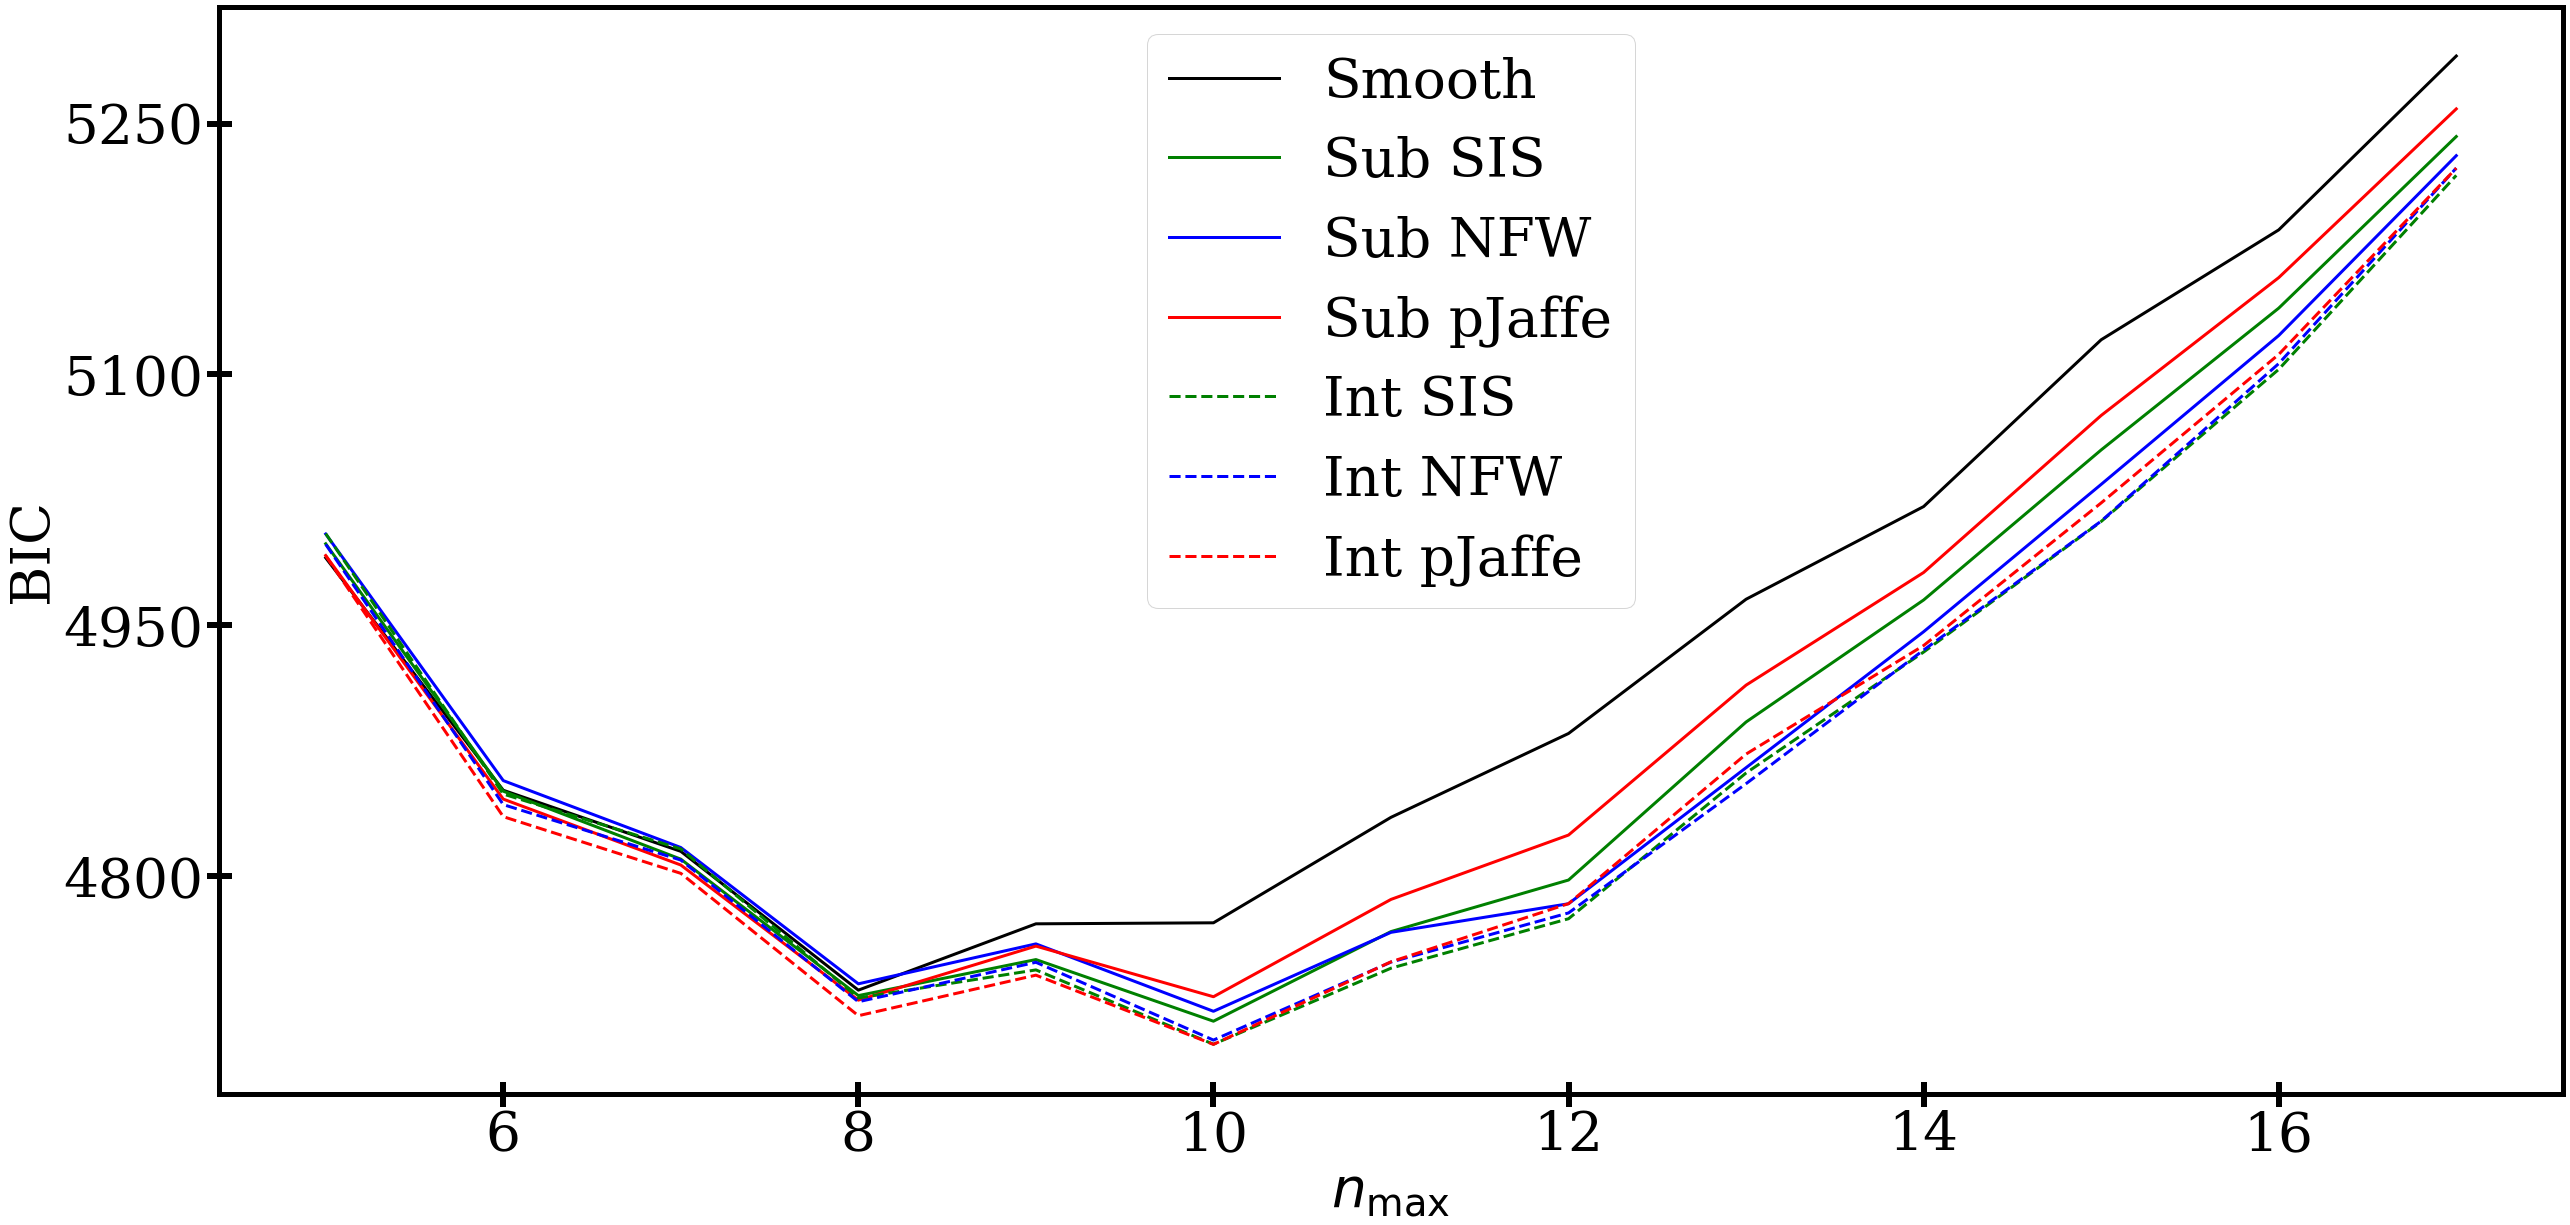

In [10]:
nmaxes = np.arange(5,18)
f, axes = plt.subplots(1, 1, figsize=(42,20), sharex=False, sharey=True)
mx = 13

axes.plot(nmaxes,bicsmo[:mx],linewidth=3.,color='black',label='Smooth')

axes.plot(nmaxes,bicsub[:mx],linewidth=3.,color='green',label='Sub SIS')
axes.plot(nmaxes,bicsubc[:mx],linewidth=3.,color='blue',label='Sub NFW')
axes.plot(nmaxes,bicsubj[:mx],linewidth=3.,color='red',label='Sub pJaffe')

axes.plot(nmaxes,bicint[:mx],linewidth=3.,linestyle='dashed',color='green',label='Int SIS')
axes.plot(nmaxes,bicintc[:mx],linewidth=3.,linestyle='dashed',color='blue',label='Int NFW')
axes.plot(nmaxes,bicintj[:mx],linewidth=3.,linestyle='dashed',color='red',label='Int pJaffe')





#axes.xaxis.set_major_locator(plt.MaxNLocator(3))
axes.yaxis.set_major_locator(plt.MaxNLocator(5))
axes.set_xlabel('$n_\mathrm{max}$')
axes.set_ylabel('BIC')
axes.set_title('')
axes.tick_params(which='major', length=25, width=6, direction='inout')
plt.legend(loc=9)
plt.show()

# Figure 6

In [11]:
truesis = np.array([ 4.60134417e-01,  2.31250785e+00, -2.52718898e-02, -1.07831760e-01,
  -1.18476805e-03,  5.92321526e-02,  3.18027723e-03, -3.39494375e-02,
   1.1931432e+01,  4.30028261e-02,  4.78860990e-01,  1.42725441e+00,
   1.04133193e-01, -6.48296295e-02,  2.60870485e-02])
truejaf = np.array([ 4.64185779e-01,  2.34815953e+00, -2.35192941e-02, -1.07958077e-01,
  -9.63874546e-03,  6.38791276e-02, -1.46043380e-03, -3.68715947e-02,
   1.58366809e+01,  5.35296363e-02,  4.73079247e-01,  1.41709587e+00,
   1.12622111e-01, -7.61218302e-02,  2.33148292e-02])
truenfw = np.array([ 4.63273354e-01,  2.32236119e+00, -2.49524044e-02, -1.08278103e-01,
   4.46176587e-03,  5.61499926e-02,  3.64251172e-03, -3.50970371e-02,
   1.56419705e+00,  5.66193361e-02,  4.73244498e-01,  1.40841152e+00,
   6.67495524e+01,  1.08158087e-01, -7.24759826e-02,  2.35818140e-02])

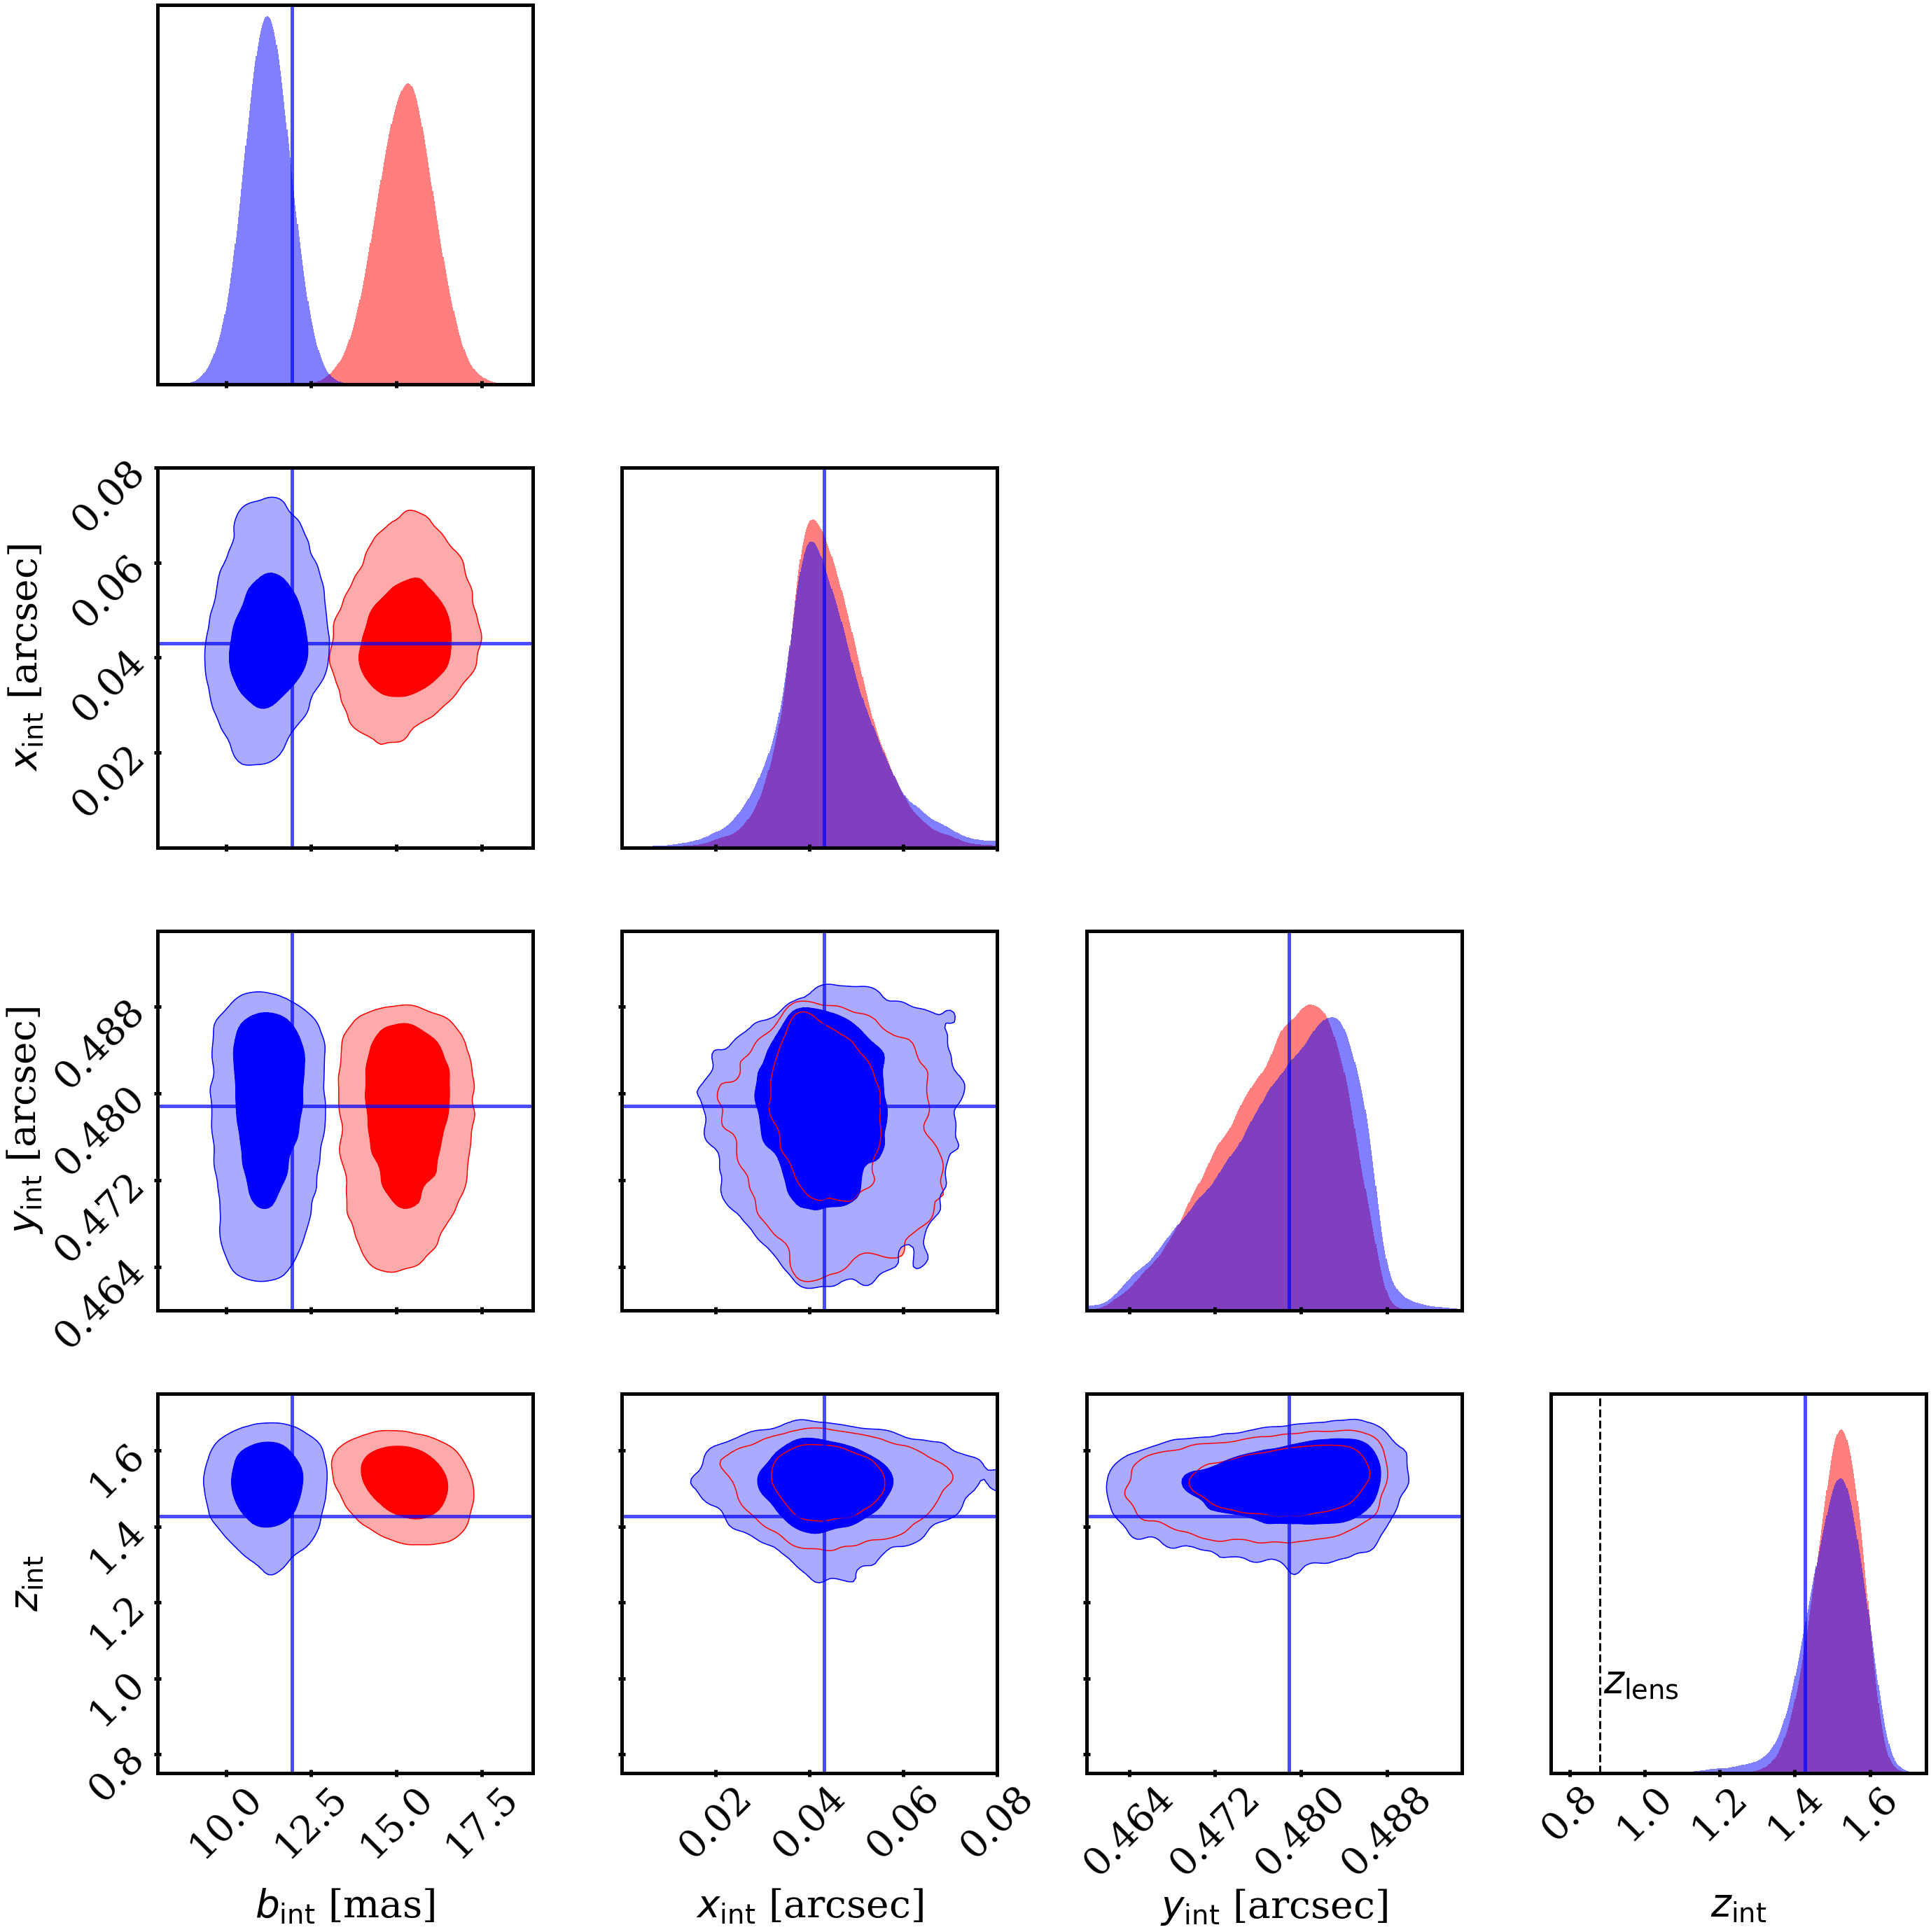

In [12]:
N = 4

fig = plt.subplots(N,N,figsize=(10*N,10*N))



span = [[8.,19.],[-0.00,0.08],[0.46,0.495],[0.75,1.75]]

quant = [0.6826894921370859,0.9544997361036416]



tfig2, taxes2 = dyplot.cornerplot(mocksisj10,span=span,dims=np.arange(8,12),quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=None,truth_color='red',labels=labls_mask_int[8:12],color='red',fig=fig,
                                  hist_kwargs=histdic,truth_kwargs=truedic)
tfig2, taxes2 = dyplot.cornerplot(mocksis10,span=span,dims=np.arange(8,12),quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=truesis[8:12],truth_color='blue',labels=labls_mask_int[8:12],color='blue',fig=fig,
                                  hist_kwargs=histdic,truth_kwargs=truedic)

taxes2[3,3].axvline(0.881,linewidth=3.,color='black',linestyle='--')
taxes2[3,3].text(0.890,1.5,'$z_\mathrm{lens}$')
taxes2[0,0].set_ylim(0.,0.6)
taxes2[1,1].set_ylim(0.,60.)
taxes2[2,2].set_ylim(0.,90.)
taxes2[3,3].set_ylim(0.,7.)

for i in range(4):
    for j in range(4):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout')
#        if j==i:
#            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
            
#        if j<i:
#            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
#            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()

# Figure 7

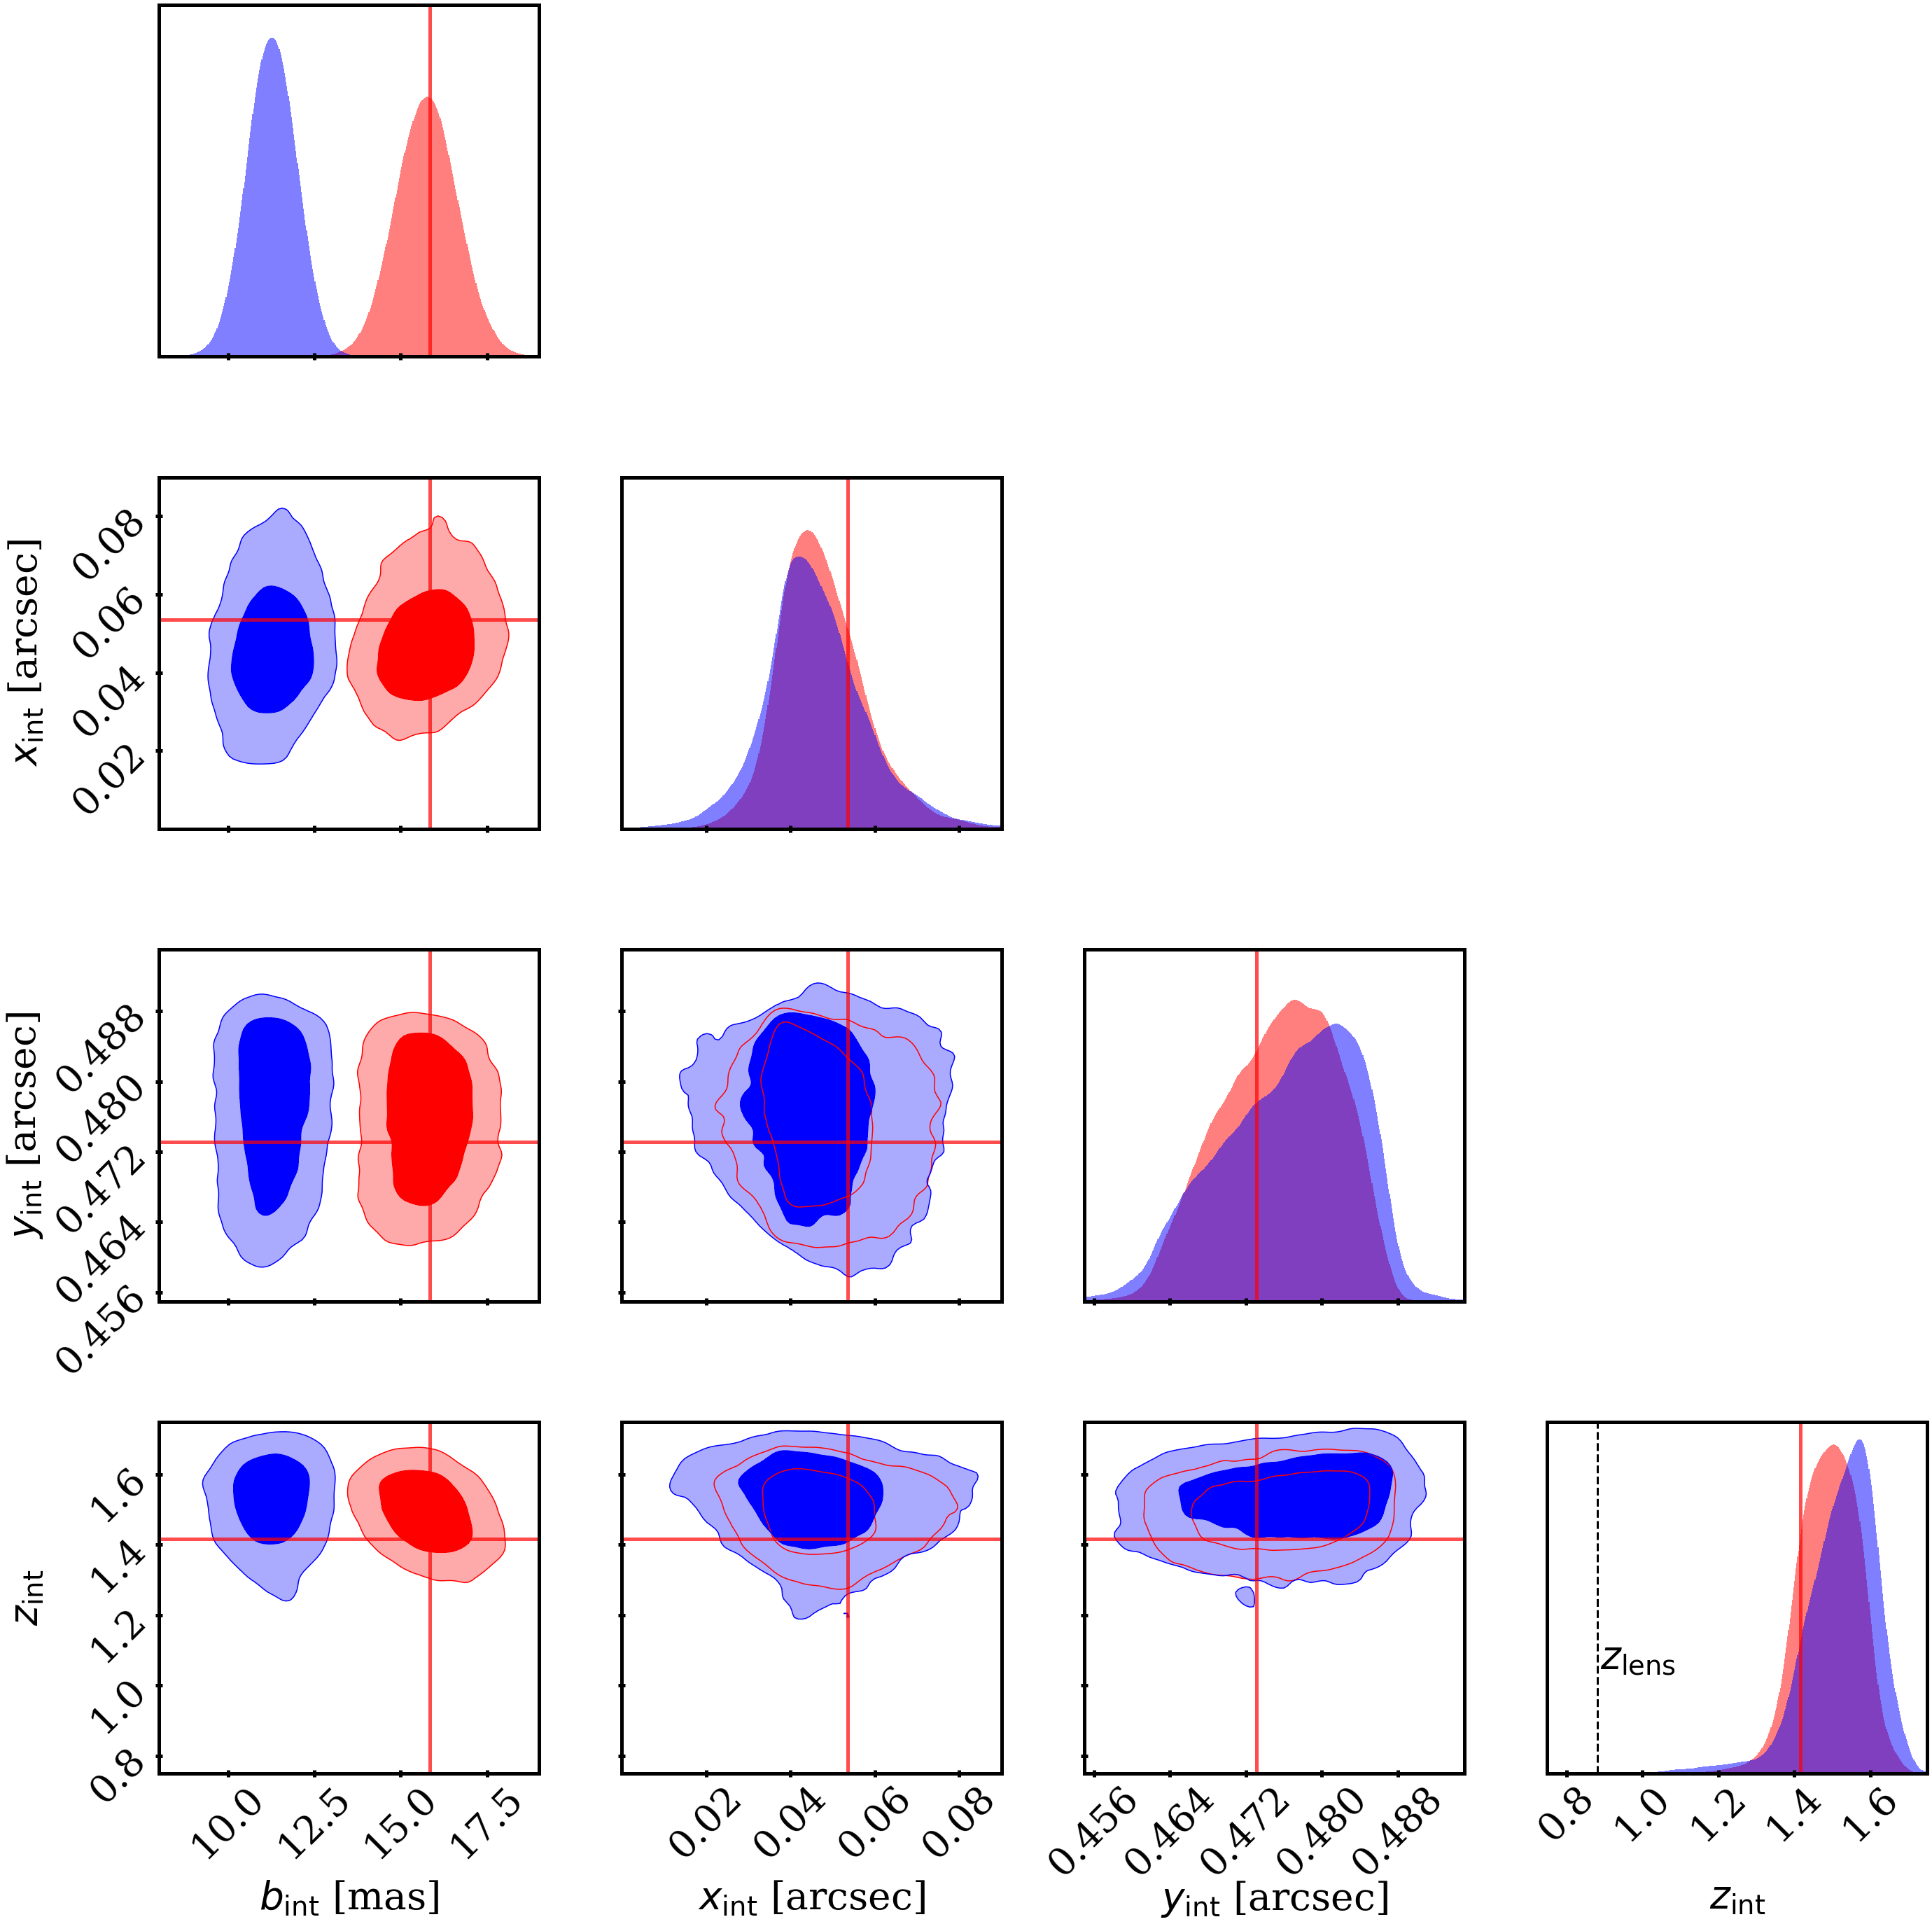

In [13]:
N = 4

fig = plt.subplots(N,N,figsize=(10*N,10*N))

span = [[8.,19.],[-0.00,0.09],[0.455,0.495],[0.75,1.75]]

quant = [0.6826894921370859,0.9544997361036416]



tfig2, taxes2 = dyplot.cornerplot(mockj10,span=span,dims=np.arange(8,12),quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=truejaf[8:12],truth_color='red',labels=labls_mask_int[8:12],color='red',fig=fig,
                                  hist_kwargs=histdic,truth_kwargs=truedic)
tfig2, taxes2 = dyplot.cornerplot(mockjsis10,span=span,dims=np.arange(8,12),quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=None,truth_color='blue',labels=labls_mask_int[8:12],color='blue',fig=fig,
                                  hist_kwargs=histdic,truth_kwargs=truedic)

taxes2[3,3].axvline(0.881,linewidth=3.,color='black',linestyle='--')
taxes2[3,3].text(0.890,1.5,'$z_\mathrm{lens}$')
taxes2[0,0].set_ylim(0.,0.6)
taxes2[1,1].set_ylim(0.,50.)
taxes2[2,2].set_ylim(0.,70.)
taxes2[3,3].set_ylim(0.,5.)

for i in range(4):
    for j in range(4):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout')
#        if j==i:
#            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
            
#        if j<i:
#            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
#            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()

# Figure 8

In [14]:
mocknfwplot,truenfwplot = getplotc(mocknfw10,truenfw)

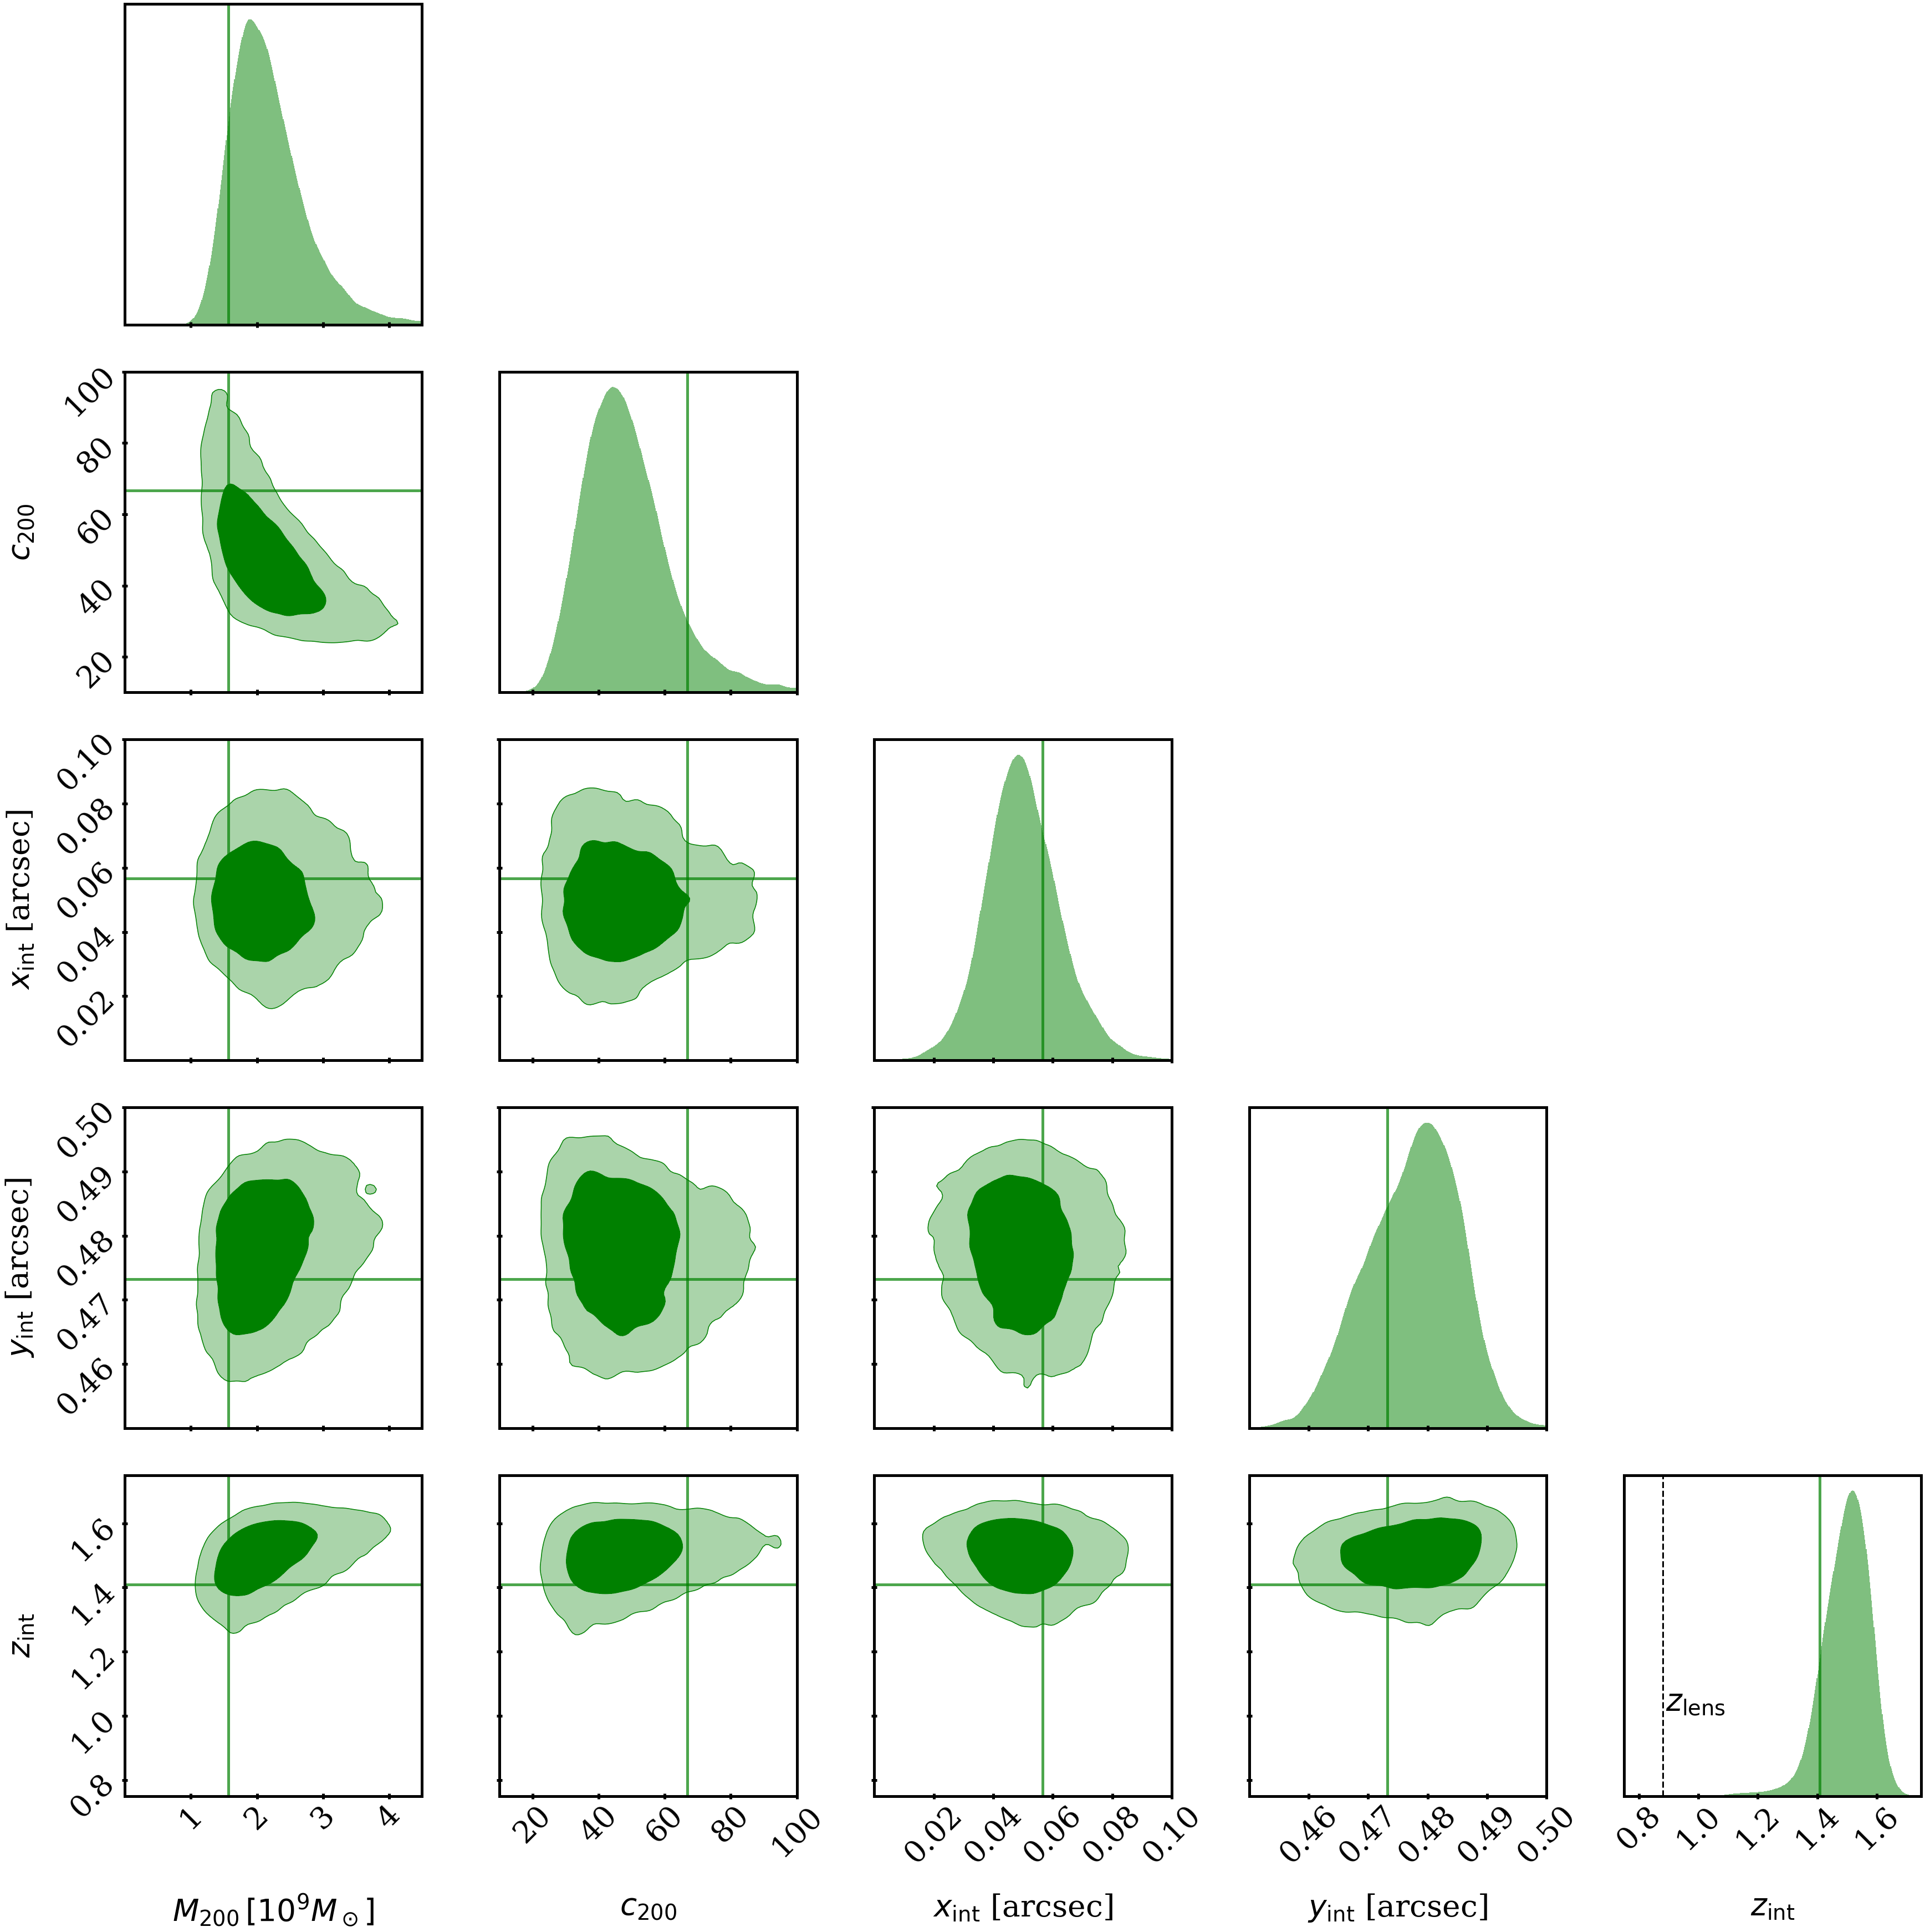

In [15]:
N = 5

fig = plt.subplots(N,N,figsize=(10*N,10*N))

span = [[0.,4.5],[10.,100.],[-0.00,0.1],[0.45,0.5],[0.75,1.75]]

quant = [0.6826894921370859,0.9544997361036416]



tfig2, taxes2 = dyplot.cornerplot(mocknfwplot,span=span,dims=np.arange(8,13),quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=truenfwplot[8:13],truth_color='green',labels=labls_mask_int_cplot[8:15],color='green',fig=fig,
                                  hist_kwargs=histdic,truth_kwargs=truedic)

taxes2[4,4].axvline(0.881,linewidth=3.,color='black',linestyle='--')
taxes2[4,4].text(0.890,1.5,'$z_\mathrm{lens}$')
#taxes2[0,0].set_ylim(0.,0.6)
#taxes2[1,1].set_ylim(0.,0.06)
#taxes2[2,2].set_ylim(0.,50.)
#taxes2[3,3].set_ylim(0.,70.)
#taxes2[4,4].set_ylim(0.,5.)

for i in range(5):
    for j in range(5):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout')
#        if j==i:
#            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
            
#        if j<i:
#            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
#            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()

# Figure 9

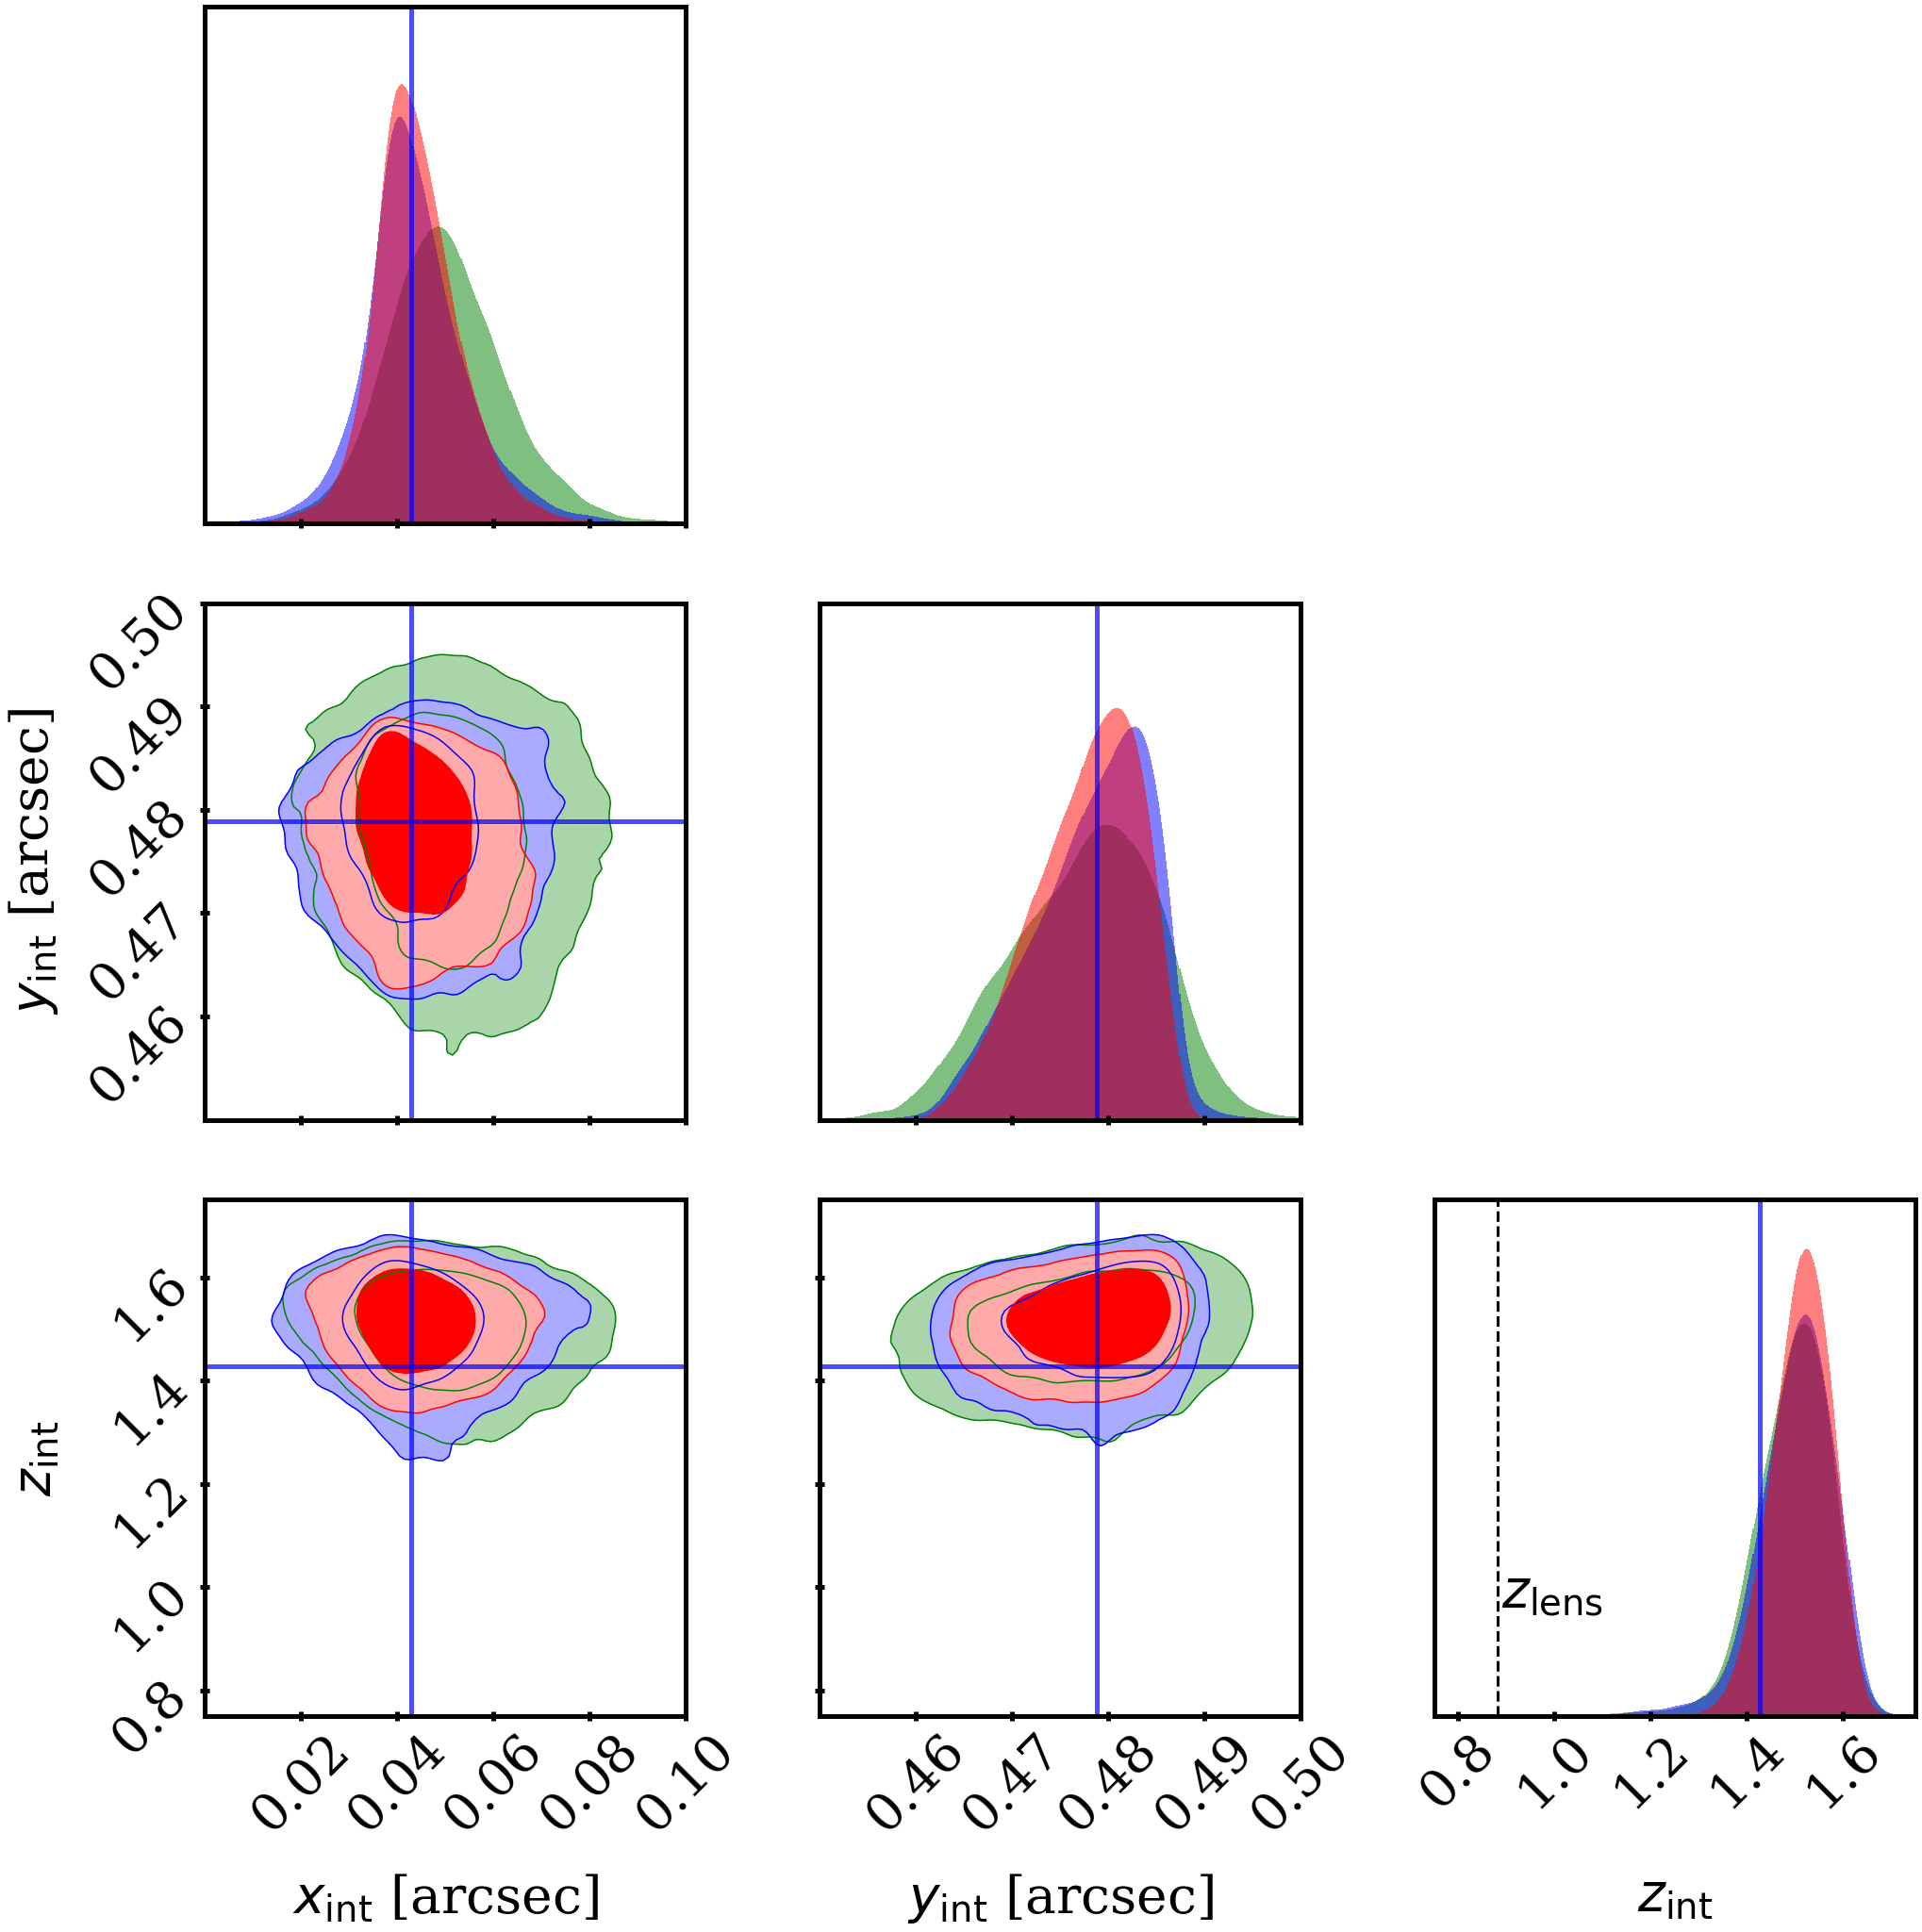

In [16]:
N = 3

fig = plt.subplots(N,N,figsize=(10*N,10*N))



span = [[-0.00,0.1],[0.45,0.5],[0.75,1.75]]

quant = [0.6826894921370859,0.9544997361036416]


tfig2, taxes2 = dyplot.cornerplot(mocknfwplot,span=span,dims=np.arange(10,13),quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=None,truth_color='green',labels=labls_mask_int[9:12],color='green',fig=fig,
                                  hist_kwargs=histdic,truth_kwargs=truedic)
tfig2, taxes2 = dyplot.cornerplot(mocksis10,span=span,dims=np.arange(9,12),quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=truesis[9:12],truth_color='blue',labels=labls_mask_int[9:12],color='blue',fig=fig,
                                  hist_kwargs=histdic,truth_kwargs=truedic)
tfig2, taxes2 = dyplot.cornerplot(mocksisj10,span=span,dims=np.arange(9,12),quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=None,truth_color='red',labels=labls_mask_int[9:12],color='red',fig=fig,
                                  hist_kwargs=histdic,truth_kwargs=truedic)



taxes2[2,2].axvline(0.881,linewidth=3.,color='black',linestyle='--')
taxes2[2,2].text(0.890,1.5,'$z_\mathrm{lens}$')
taxes2[0,0].set_ylim(0.,60.)
taxes2[1,1].set_ylim(0.,90.)
taxes2[2,2].set_ylim(0.,7.)

for i in range(3):
    for j in range(3):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout')
#        if j==i:
#            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
            
#        if j<i:
#            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
#            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()

# Figure 10

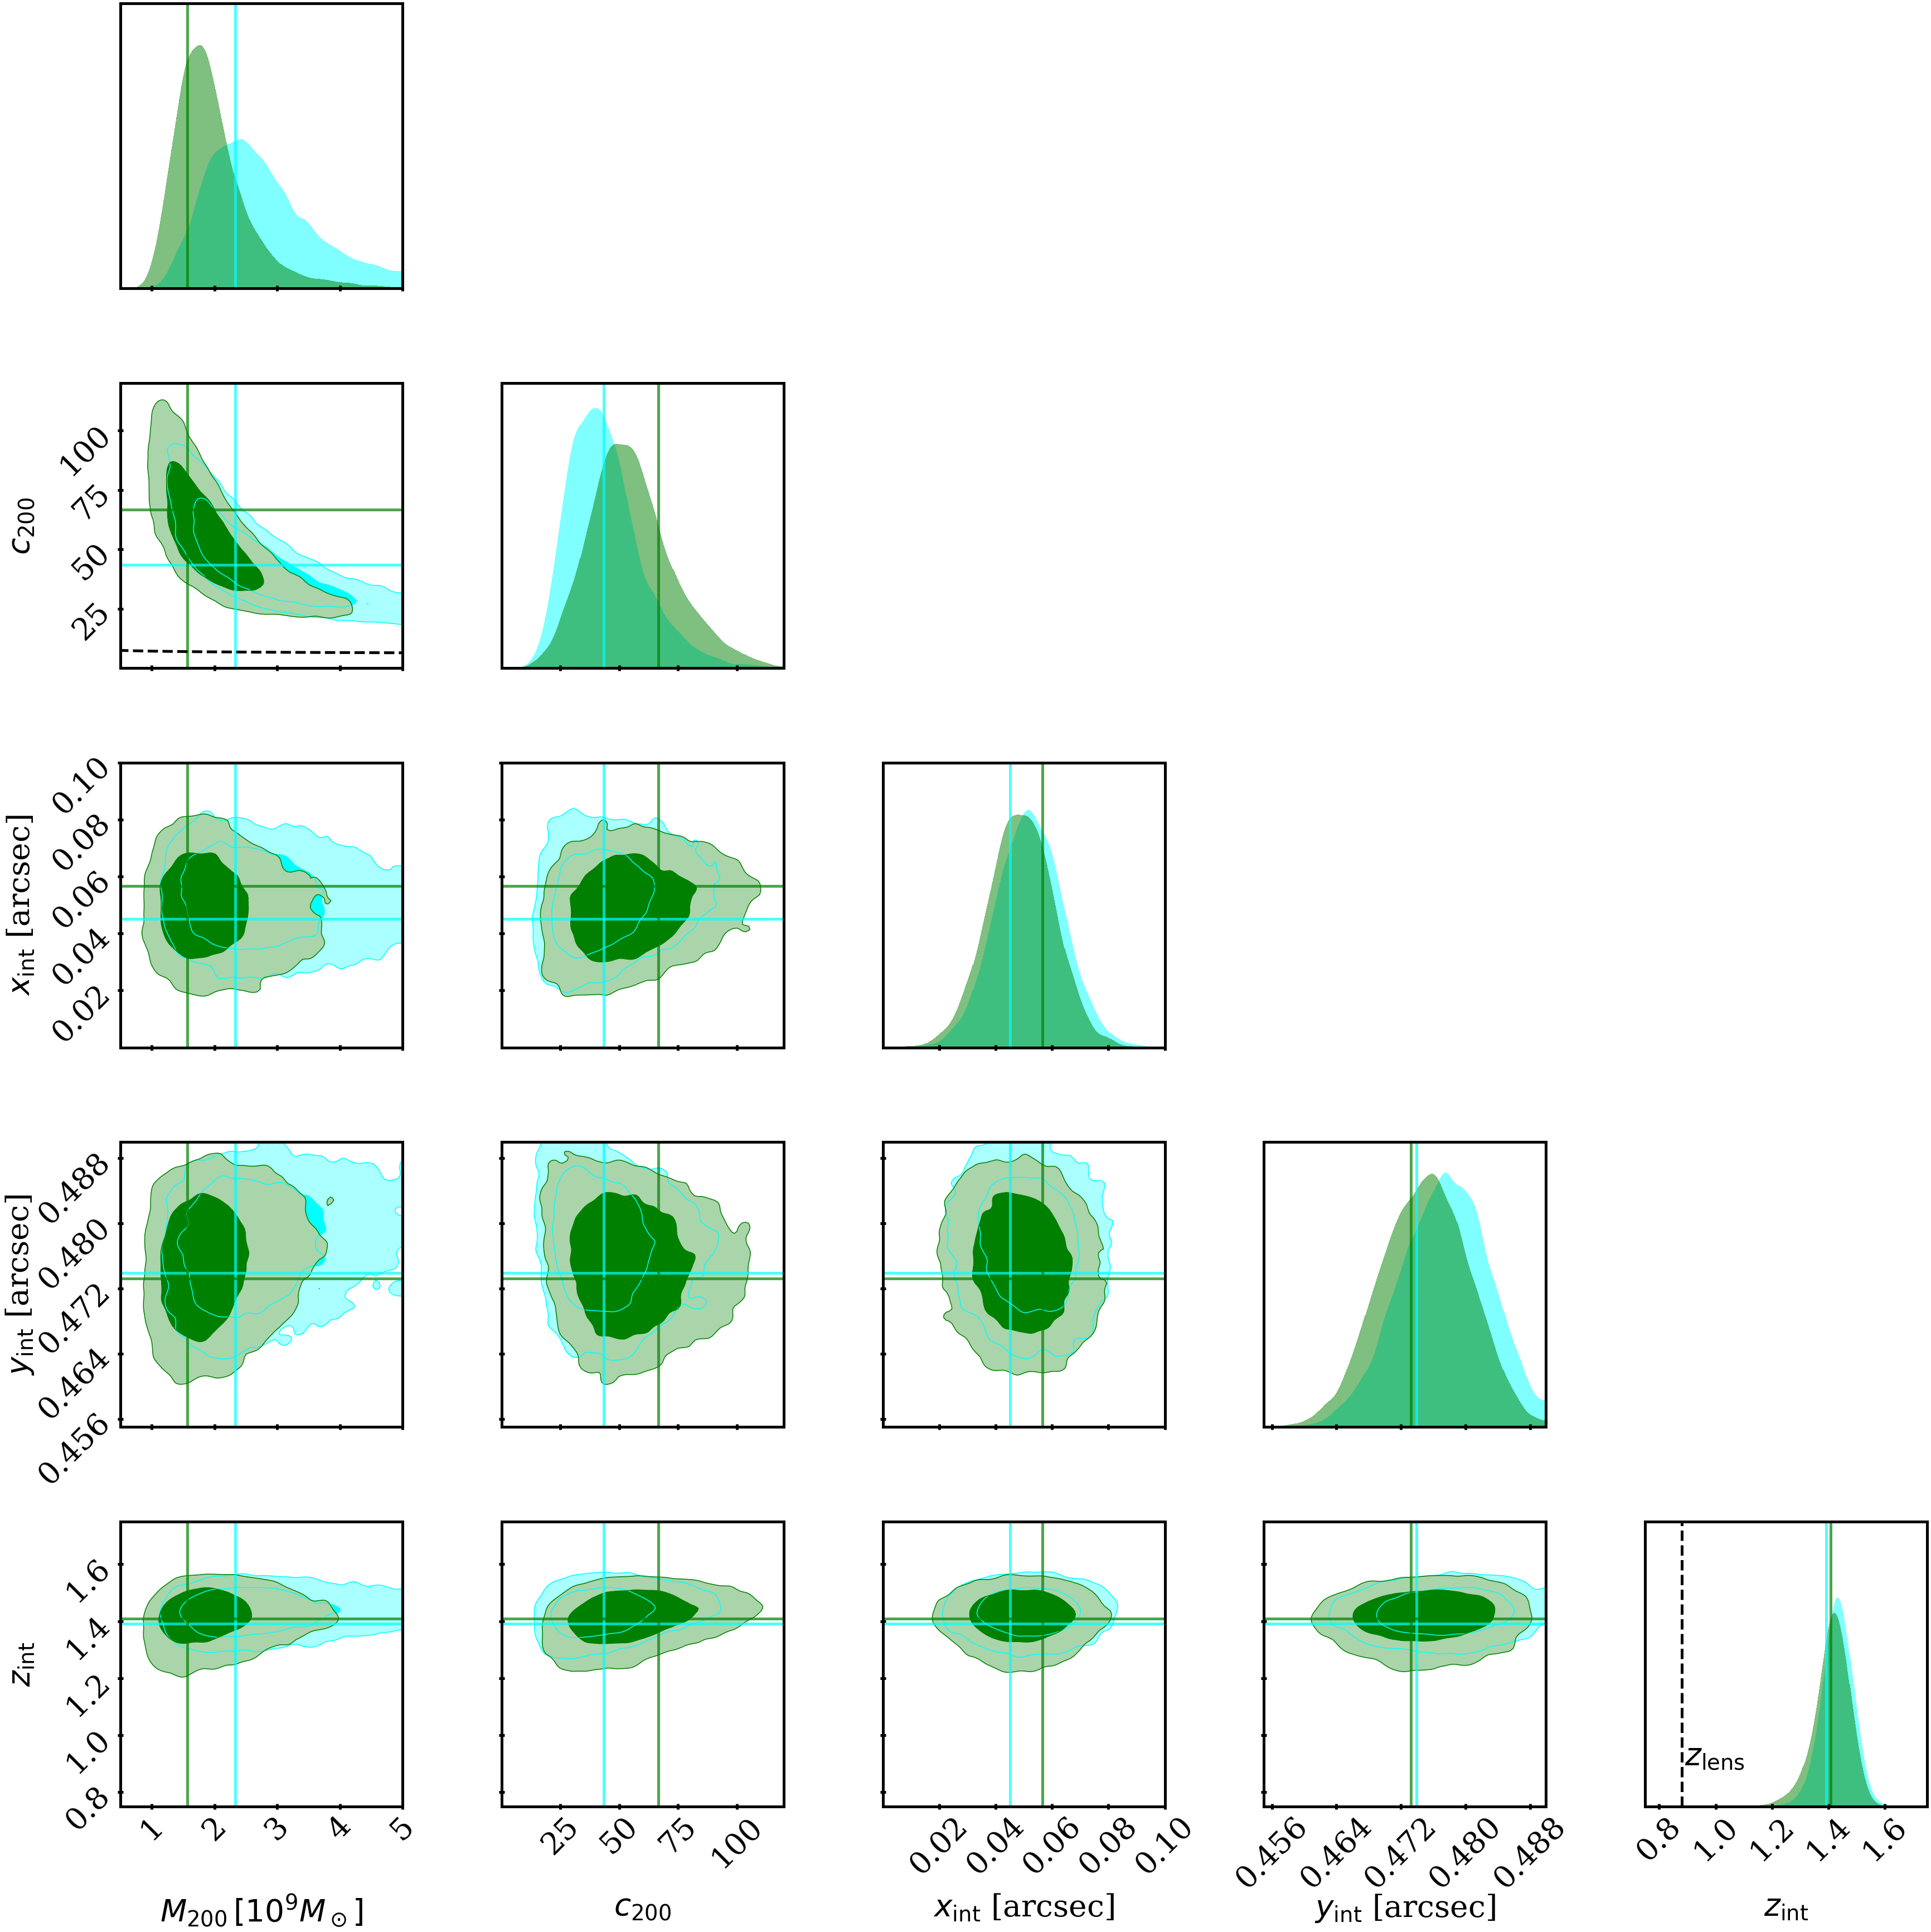

In [17]:
masses = np.linspace(0.01,5.,200)
massinput = np.log10(masses*1e9) - np.log10(cosmo.h)

concens = np.power(10.,c200vsM200(massinput,1.42))

N = 5

fig = plt.subplots(N,N,figsize=(10*N,10*N))

span = [[0.5,5.0],[0.,120.],[-0.00,0.10],[0.455,0.49],[0.75,1.75]]

quant = [0.6826894921370859,0.9544997361036416]

intcplot,intcbestplot = getplotc(intcs[5],intcbest[5])
intcplot2,intcbestplot2 = getplotc(intcs[6],intcbest[6])

tfig2, taxes2 = dyplot.cornerplot(intcplot2,span=span,dims=np.arange(8,13),quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot2[8:13],truth_color='cyan',labels=labls_mask_int_cplot[8:13],color='cyan',fig=fig,
                                  hist_kwargs=histdic,truth_kwargs=truedic)
tfig2, taxes2 = dyplot.cornerplot(intcplot,span=span,dims=np.arange(8,13),quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbestplot[8:13],truth_color='green',labels=labls_mask_int_cplot[8:13],color='green',fig=fig,
                                  hist_kwargs=histdic,truth_kwargs=truedic)


taxes2[4,4].axvline(0.881,linewidth=5.,color='black',linestyle='--')
taxes2[4,4].text(0.890,1.5,'$z_\mathrm{lens}$')
taxes2[0,0].set_ylim(0.,1.)
taxes2[1,1].set_ylim(0.,0.03)
taxes2[2,2].set_ylim(0.,40.)
taxes2[3,3].set_ylim(0.,80.)
taxes2[4,4].set_ylim(0.,10.)

taxes2[1,0].plot(masses,concens,linewidth=5.,color='black',linestyle='--')

for i in range(5):
    for j in range(5):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout')
#        if j==i:
#            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
            
#        if j<i:
#            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
#            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()

# Figure 11

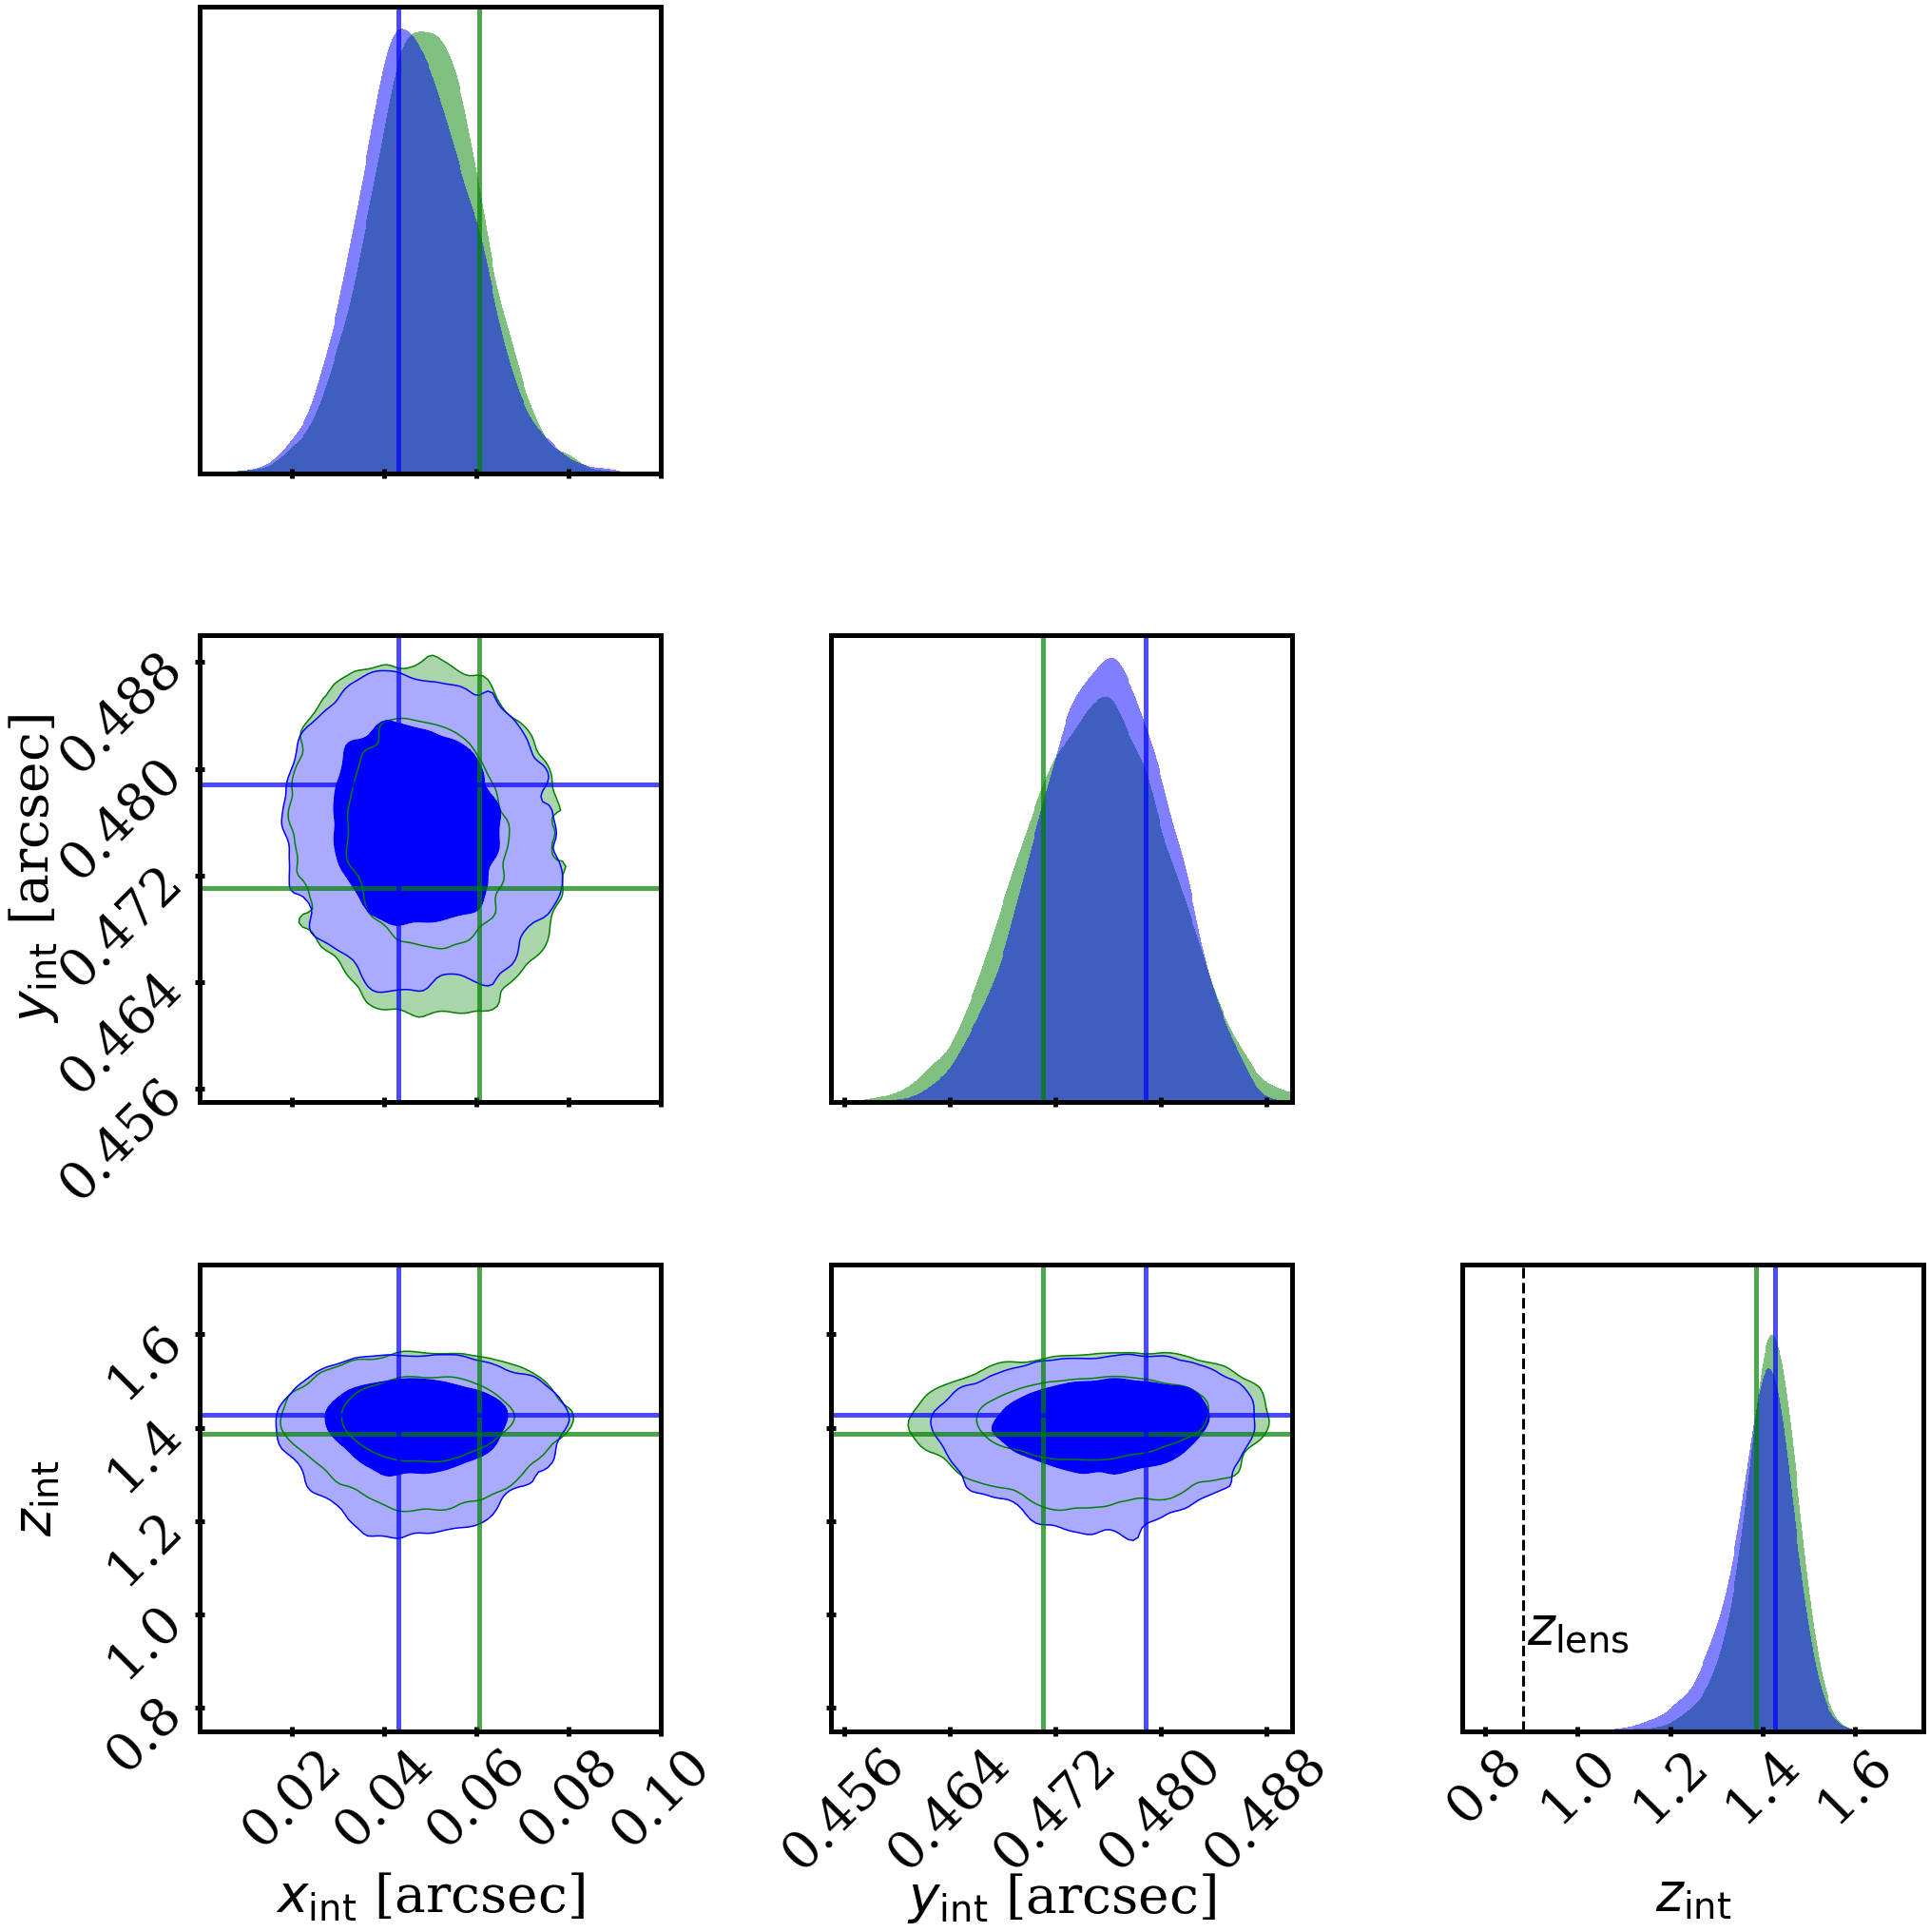

In [18]:
N = 3

fig = plt.subplots(N,N,figsize=(10*N,10*N))

span = [[-0.00,0.10],[0.455,0.49],[0.75,1.75]]

quant = [0.6826894921370859,0.9544997361036416]



tfig2, taxes2 = dyplot.cornerplot(intc10,span=span,dims=np.arange(9,12),quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intcbest[0][9:12],truth_color='green',labels=labls_mask_int_c[9:12],color='green',fig=fig,
                                  hist_kwargs=histdic,truth_kwargs=truedic)
tfig2, taxes2 = dyplot.cornerplot(ints[5],span=span,dims=np.arange(9,12),quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intbest[5][9:12],truth_color='blue',labels=labls_mask_int[9:12],color='blue',fig=fig,
                                  hist_kwargs=histdic,truth_kwargs=truedic)

taxes2[2,2].axvline(0.881,linewidth=3.,color='black',linestyle='--')
taxes2[2,2].text(0.890,1.5,'$z_\mathrm{lens}$')
taxes2[2,2].set_ylim(0.,8.0)

for i in range(3):
    for j in range(3):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout')
#        if j==i:
#            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
            
#        if j<i:
#            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
#            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()

# FIGURE 12

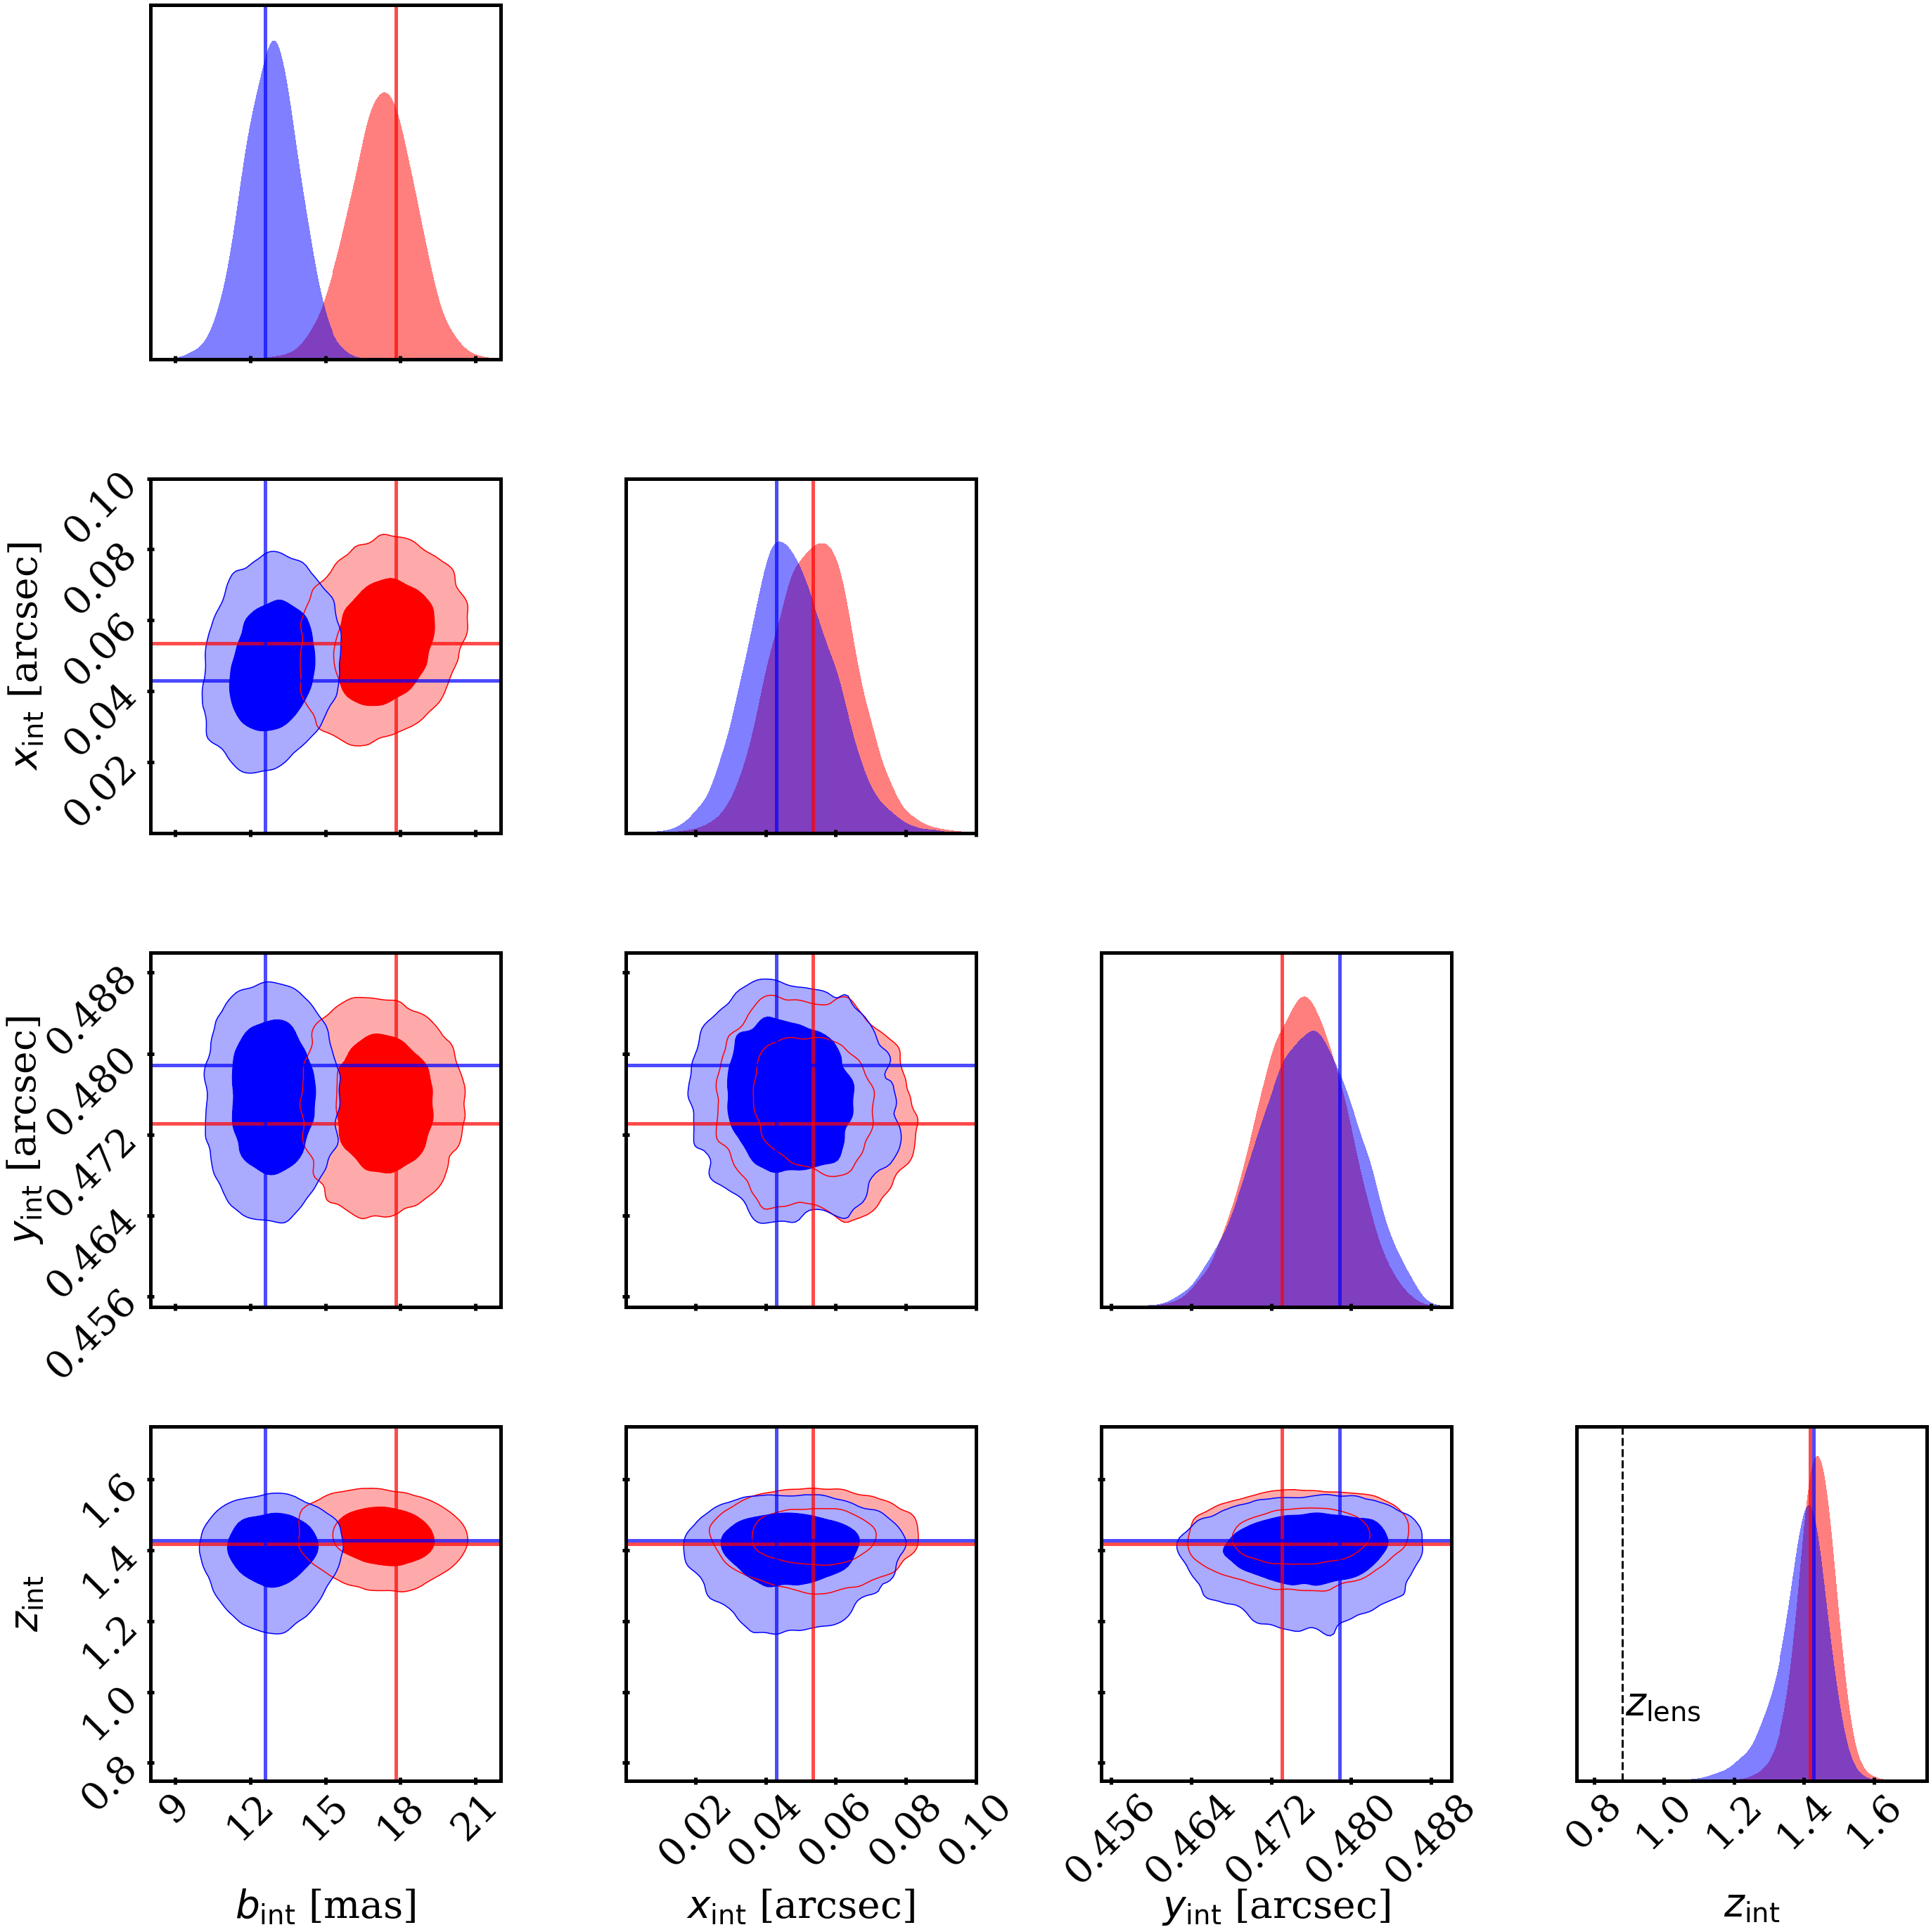

In [19]:
N = 4

fig = plt.subplots(N,N,figsize=(10*N,10*N))

matplotlib.rcParams['axes.linewidth'] = 5.0 #set the value globally

span = [[8.,22.],[-0.00,0.10],[0.455,0.49],[0.75,1.75]]

quant = [0.6826894921370859,0.9544997361036416]



tfig2, taxes2 = dyplot.cornerplot(intjs[5],span=span,dims=np.arange(8,12),quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intjbest[5][8:12],truth_color='red',labels=labls_mask_int[8:12],color='red',fig=fig,
                                  hist_kwargs=histdic,truth_kwargs=truedic)
tfig2, taxes2 = dyplot.cornerplot(ints[5],span=span,dims=np.arange(8,12),quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=intbest[5][8:12],truth_color='blue',labels=labls_mask_int[8:12],color='blue',fig=fig,
                                  hist_kwargs=histdic,truth_kwargs=truedic)

taxes2[3,3].axvline(0.881,linewidth=3.,color='black',linestyle='--')
taxes2[3,3].text(0.890,1.5,'$z_\mathrm{lens}$')
taxes2[0,0].set_ylim(0.,0.40)
taxes2[1,1].set_ylim(0.,40.)
taxes2[2,2].set_ylim(0.,100.)
taxes2[3,3].set_ylim(0.,8.)

for i in range(4):
    for j in range(4):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout')
#        if j==i:
#            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
            
#        if j<i:
#            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
#            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()

# Trace Plot

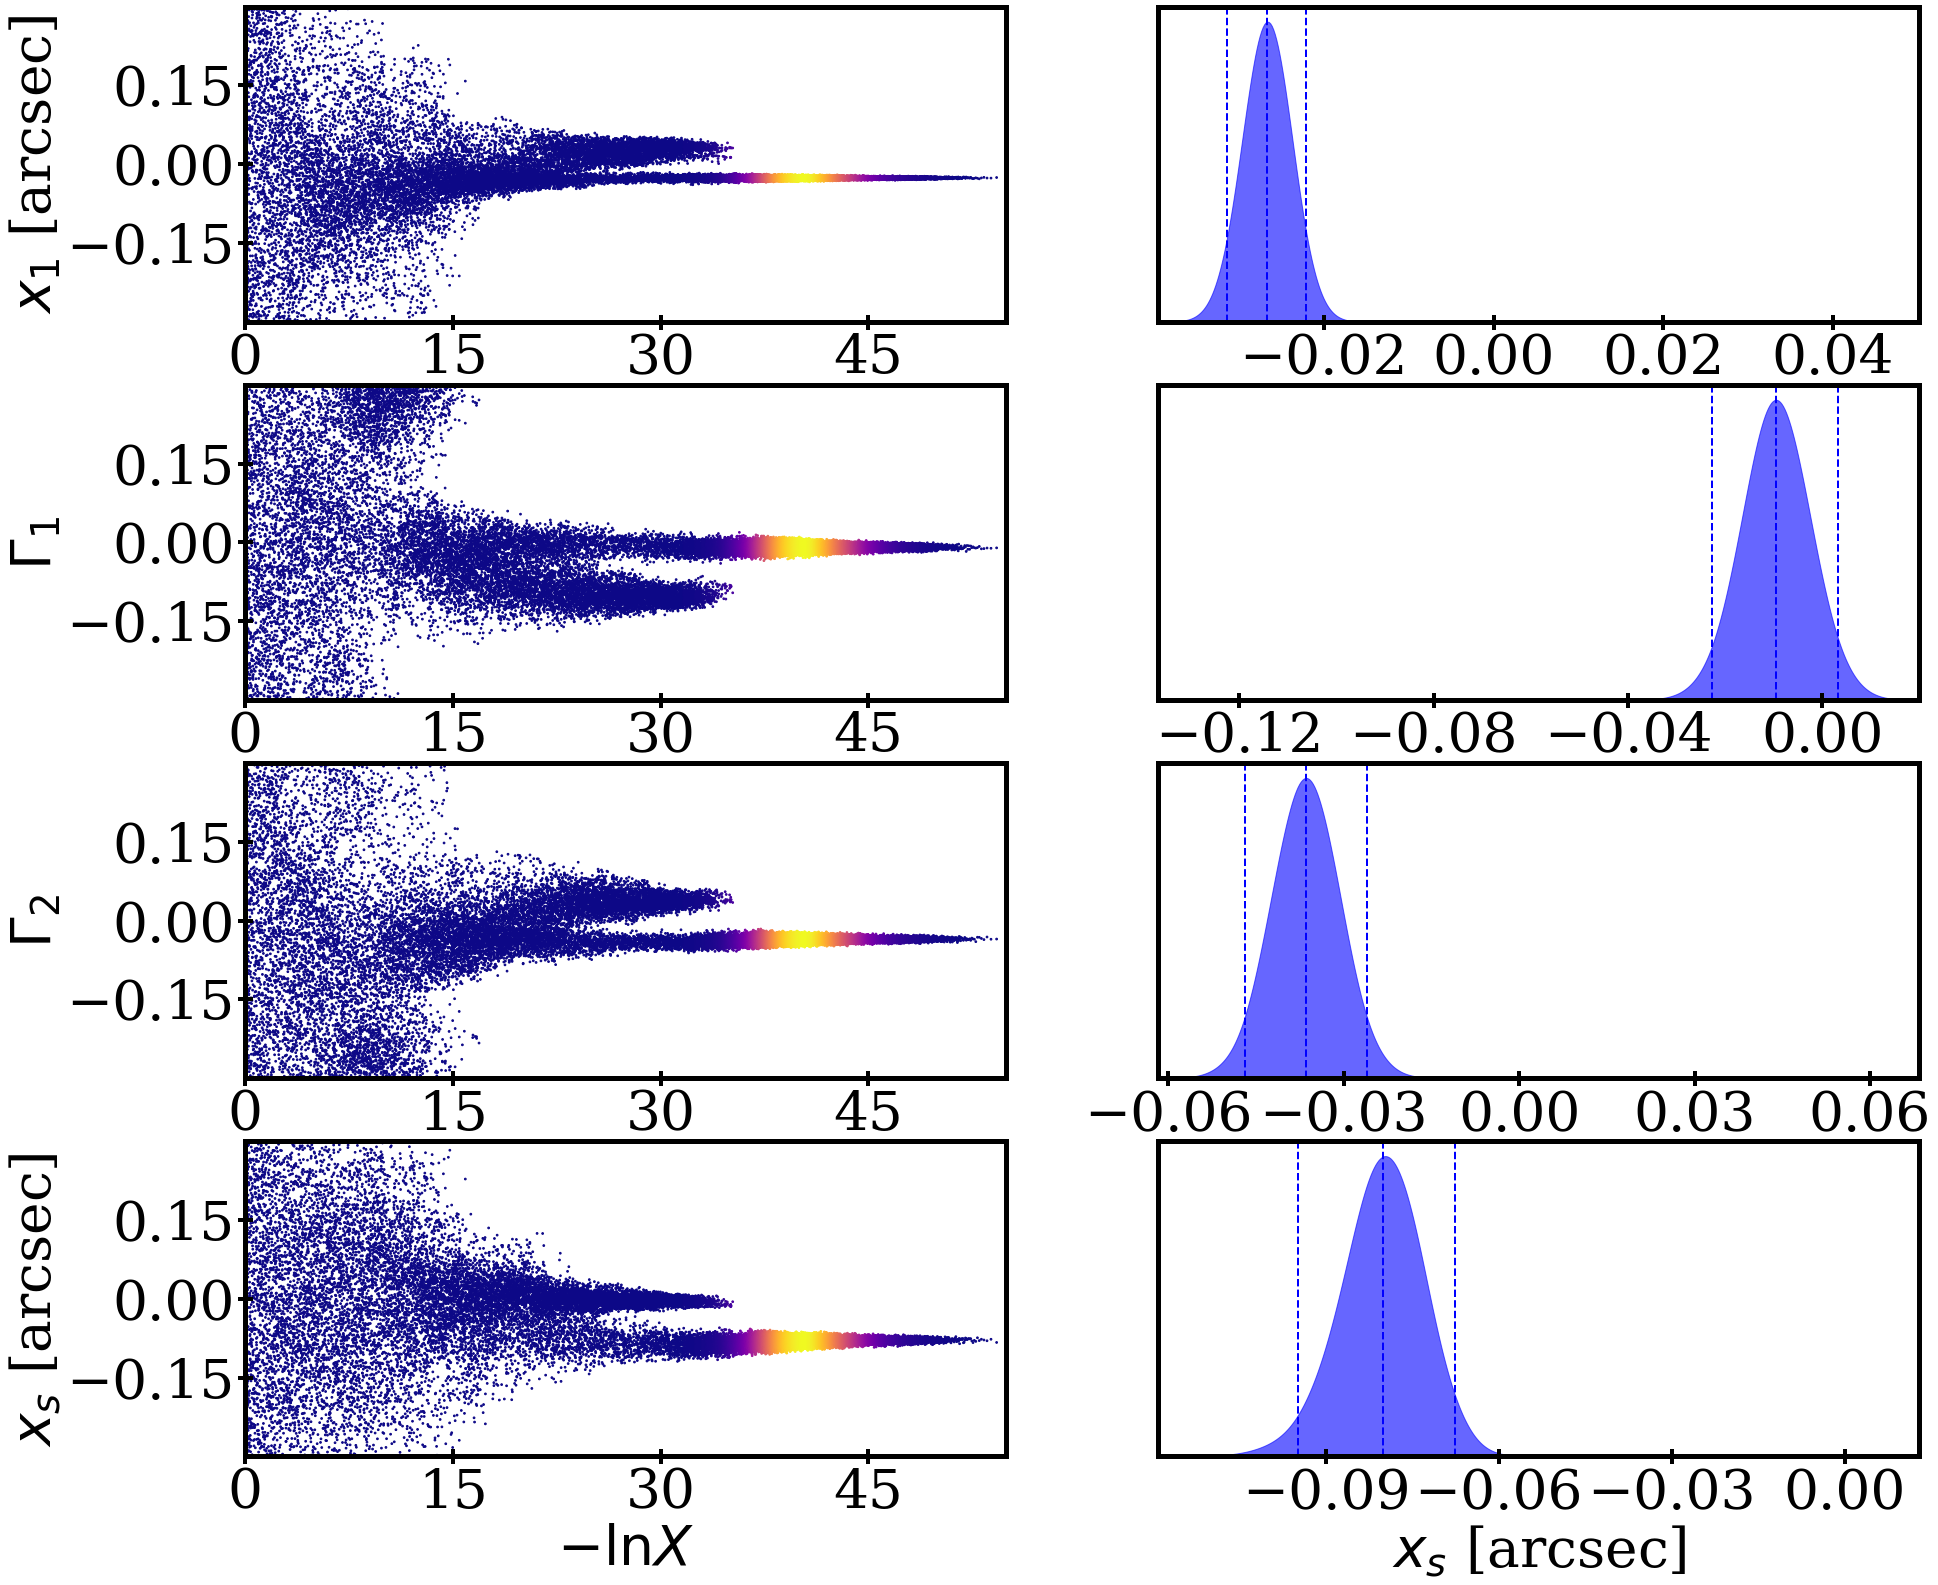

In [20]:
dim = [2,6,7,12]

labls = [labls_mask_sub[2],labls_mask_sub[6],labls_mask_sub[7],labls_mask_sub[12]]


fig = plt.subplots(4,2,figsize=(30,80./3.))
tfig, taxes = dyplot.traceplot(subjs[5],dims=dim,fig=fig,labels=labls)
#taxes[0,0].yaxis.set_major_locator(plt.MaxNLocator(3))
#taxes[1,0].yaxis.set_major_locator(plt.MaxNLocator(3))
#taxes[2,0].yaxis.set_major_locator(plt.MaxNLocator(3))

#taxes[0,0].set_ylim(0.03,0.07)
#taxes[1,0].set_ylim(-0.1,0.05)
#taxes[2,0].set_ylim(-0.05,0.075)


for i in range(2):
    for j in range(4):
        taxes[j,i].tick_params(which='major', length=15, width=4, direction='inout')
plt.show()

# Appendix Plots

In [21]:
intnplot = copy.deepcopy(intns[5])
intnbestplot = copy.deepcopy(intnbest[5])

massinput = np.log10(intns[5].samples[:,8]*1e9) - np.log10(cosmo.h)


intnplot.samples[:,8] = np.log10(intns[5].samples[:,8]*1e9)
intnplot.samples[:,9] = np.log10(np.power(10.,c200vsM200(massinput,1.42)))
intnplot.samples[:,10] = intns[5].samples[:,9]
intnplot.samples[:,11] = intns[5].samples[:,10]
intnplot.samples[:,12] = intns[5].samples[:,11]


intnbestplot[8] = np.log10(intnbest[5][8])
intnbestplot[9] = np.log10(np.power(10.,c200vsM200(intbest[5][8],1.42)))
intnbestplot[10] = intnbest[5][9]
intnbestplot[11] = intnbest[5][10]
intnbestplot[12] = intnbest[5][11]

In [22]:
labls_mask_int_cplot2 = ['$\\theta_E$', '$\\gamma$', '$x_1$ [arcsec]', '$x_2$ [arcsec]', '$e_1$', '$e_2$', '$\\Gamma_1$', '$\\Gamma_2$', 
 '$\log_{10}(M_\\mathrm{200}/[10^{9}\,M_\\odot])$', '$\log_{10}(c_{200})$', '$x_\\mathrm{int}$ [arcsec]', '$y_\\mathrm{int}$ [arcsec]', '$z_\\mathrm{int}$', 
 '$\\delta$ [arcsec]', '$x_s$ [arcsec]', '$y_s$ [arcsec]']

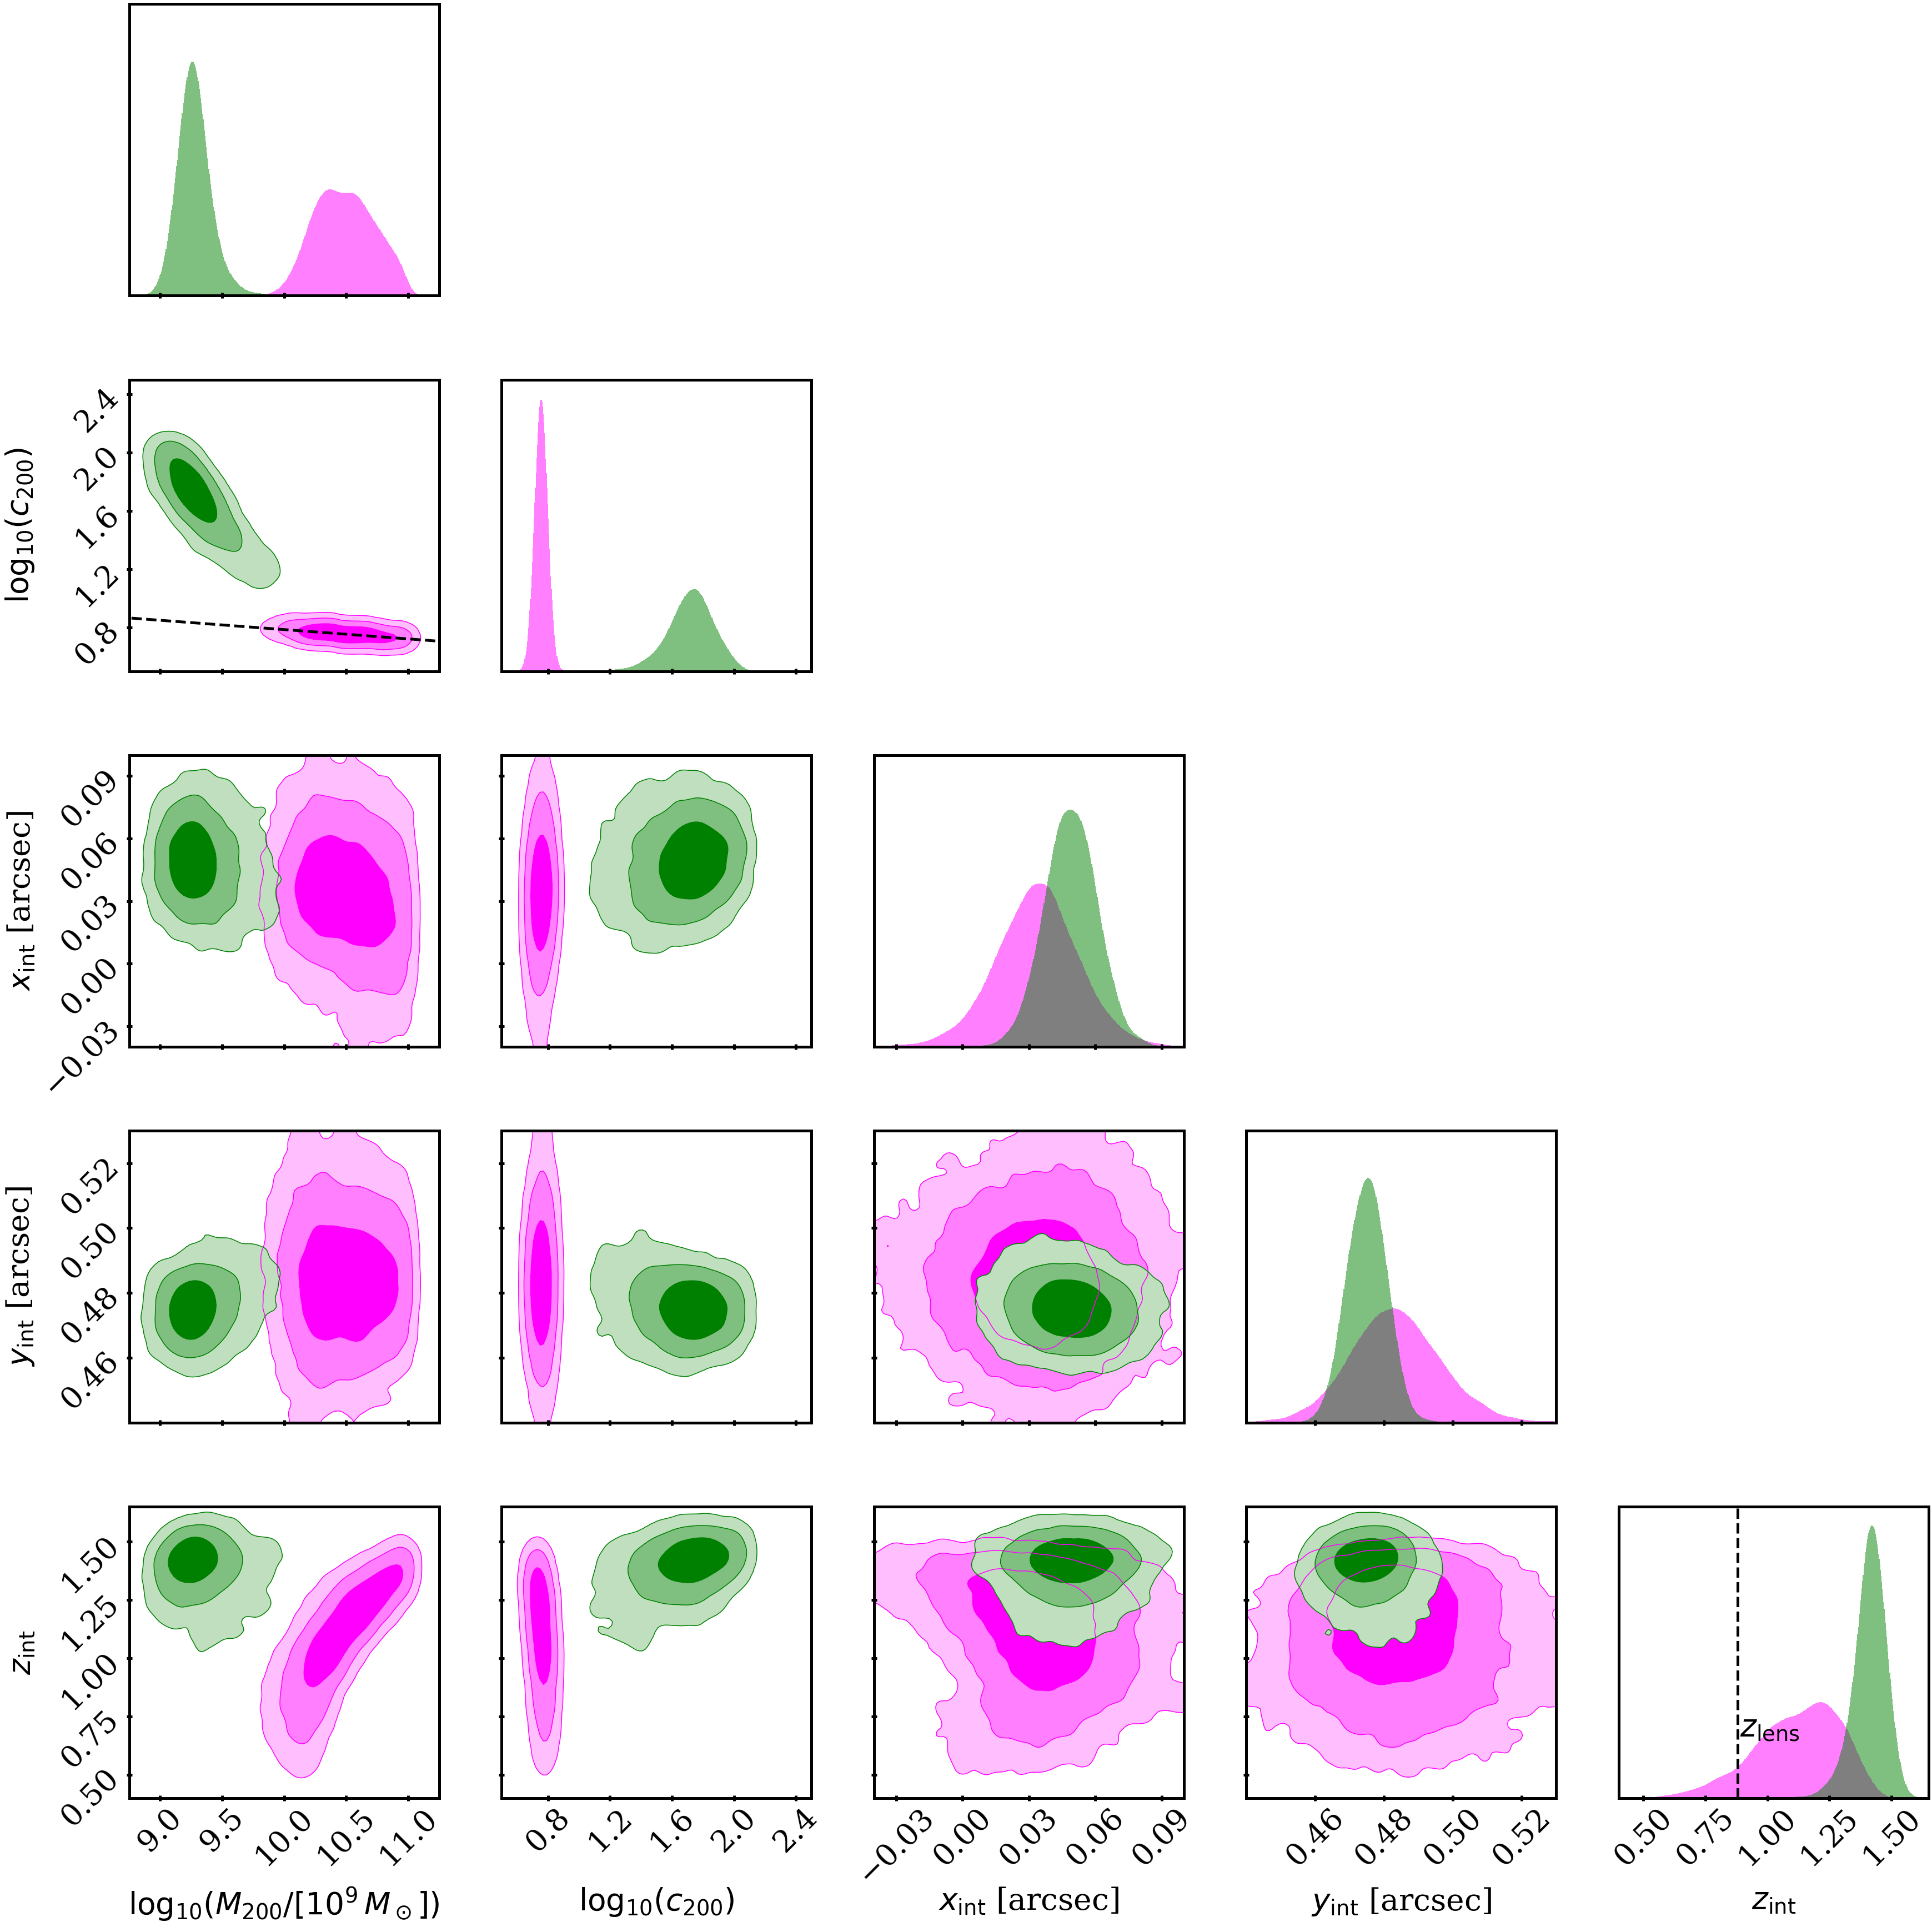

In [23]:
masses = np.linspace(0.01,1000.,200)
massinput = np.log10(masses*1e9) - np.log10(cosmo.h)

concens = np.power(10.,c200vsM200(massinput,1.43))

N = 5

fig = plt.subplots(N,N,figsize=(10*N,10*N))

span = [[8.75,11.25],[0.5,2.5],[-0.04,0.1],[0.44,0.53],[0.4,1.65]]

quant = [0.6826894921370859,0.9544997361036416,0.997300203936740]

intcplot,intcbestplot = getplotc(intcs[5],intcbest[5])

intcplot.samples[:,8] = np.log10(intcplot.samples[:,8]*1e9)
intcplot.samples[:,9] = np.log10(intcplot.samples[:,9])


tfig2, taxes2 = dyplot.cornerplot(intnplot,span=span,dims=np.arange(8,13),quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=None,truth_color='magenta',labels=labls_mask_int_cplot2[8:13],color='magenta',fig=fig,
                                  hist_kwargs=histdic,truth_kwargs=truedic)
tfig2, taxes2 = dyplot.cornerplot(intcplot,span=span,dims=np.arange(8,13),quantiles=[],quantiles_2d=quant,show_titles=False,
                                  truths=None,truth_color='green',labels=labls_mask_int_cplot2[8:13],color='green',fig=fig,
                                  hist_kwargs=histdic,truth_kwargs=truedic)





taxes2[4,4].axvline(0.881,linewidth=5.,color='black',linestyle='--')
taxes2[4,4].text(0.890,1.5,'$z_\mathrm{lens}$')
taxes2[0,0].set_ylim(0.,4.)
taxes2[1,1].set_ylim(0.,10.)
taxes2[2,2].set_ylim(0.,40.)
taxes2[3,3].set_ylim(0.,80.)
taxes2[4,4].set_ylim(0.,7.)

taxes2[1,0].plot(np.log10(masses*1e9),np.log10(concens),linewidth=5.,color='black',linestyle='--')

for i in range(5):
    for j in range(5):
        taxes2[i,j].tick_params(which='major', length=10, width=5., direction='inout')
#        if j==i:
#            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
            
#        if j<i:
#            taxes2[i,j].xaxis.set_major_locator(plt.MaxNLocator(4))
#            taxes2[i,j].yaxis.set_major_locator(plt.MaxNLocator(4))
plt.tight_layout()

In [138]:
# Bayes Factor
print(np.log10(np.exp(byintc[5] - byintn[5])))

2.905183717096103


# Wide subhalo prior comparison

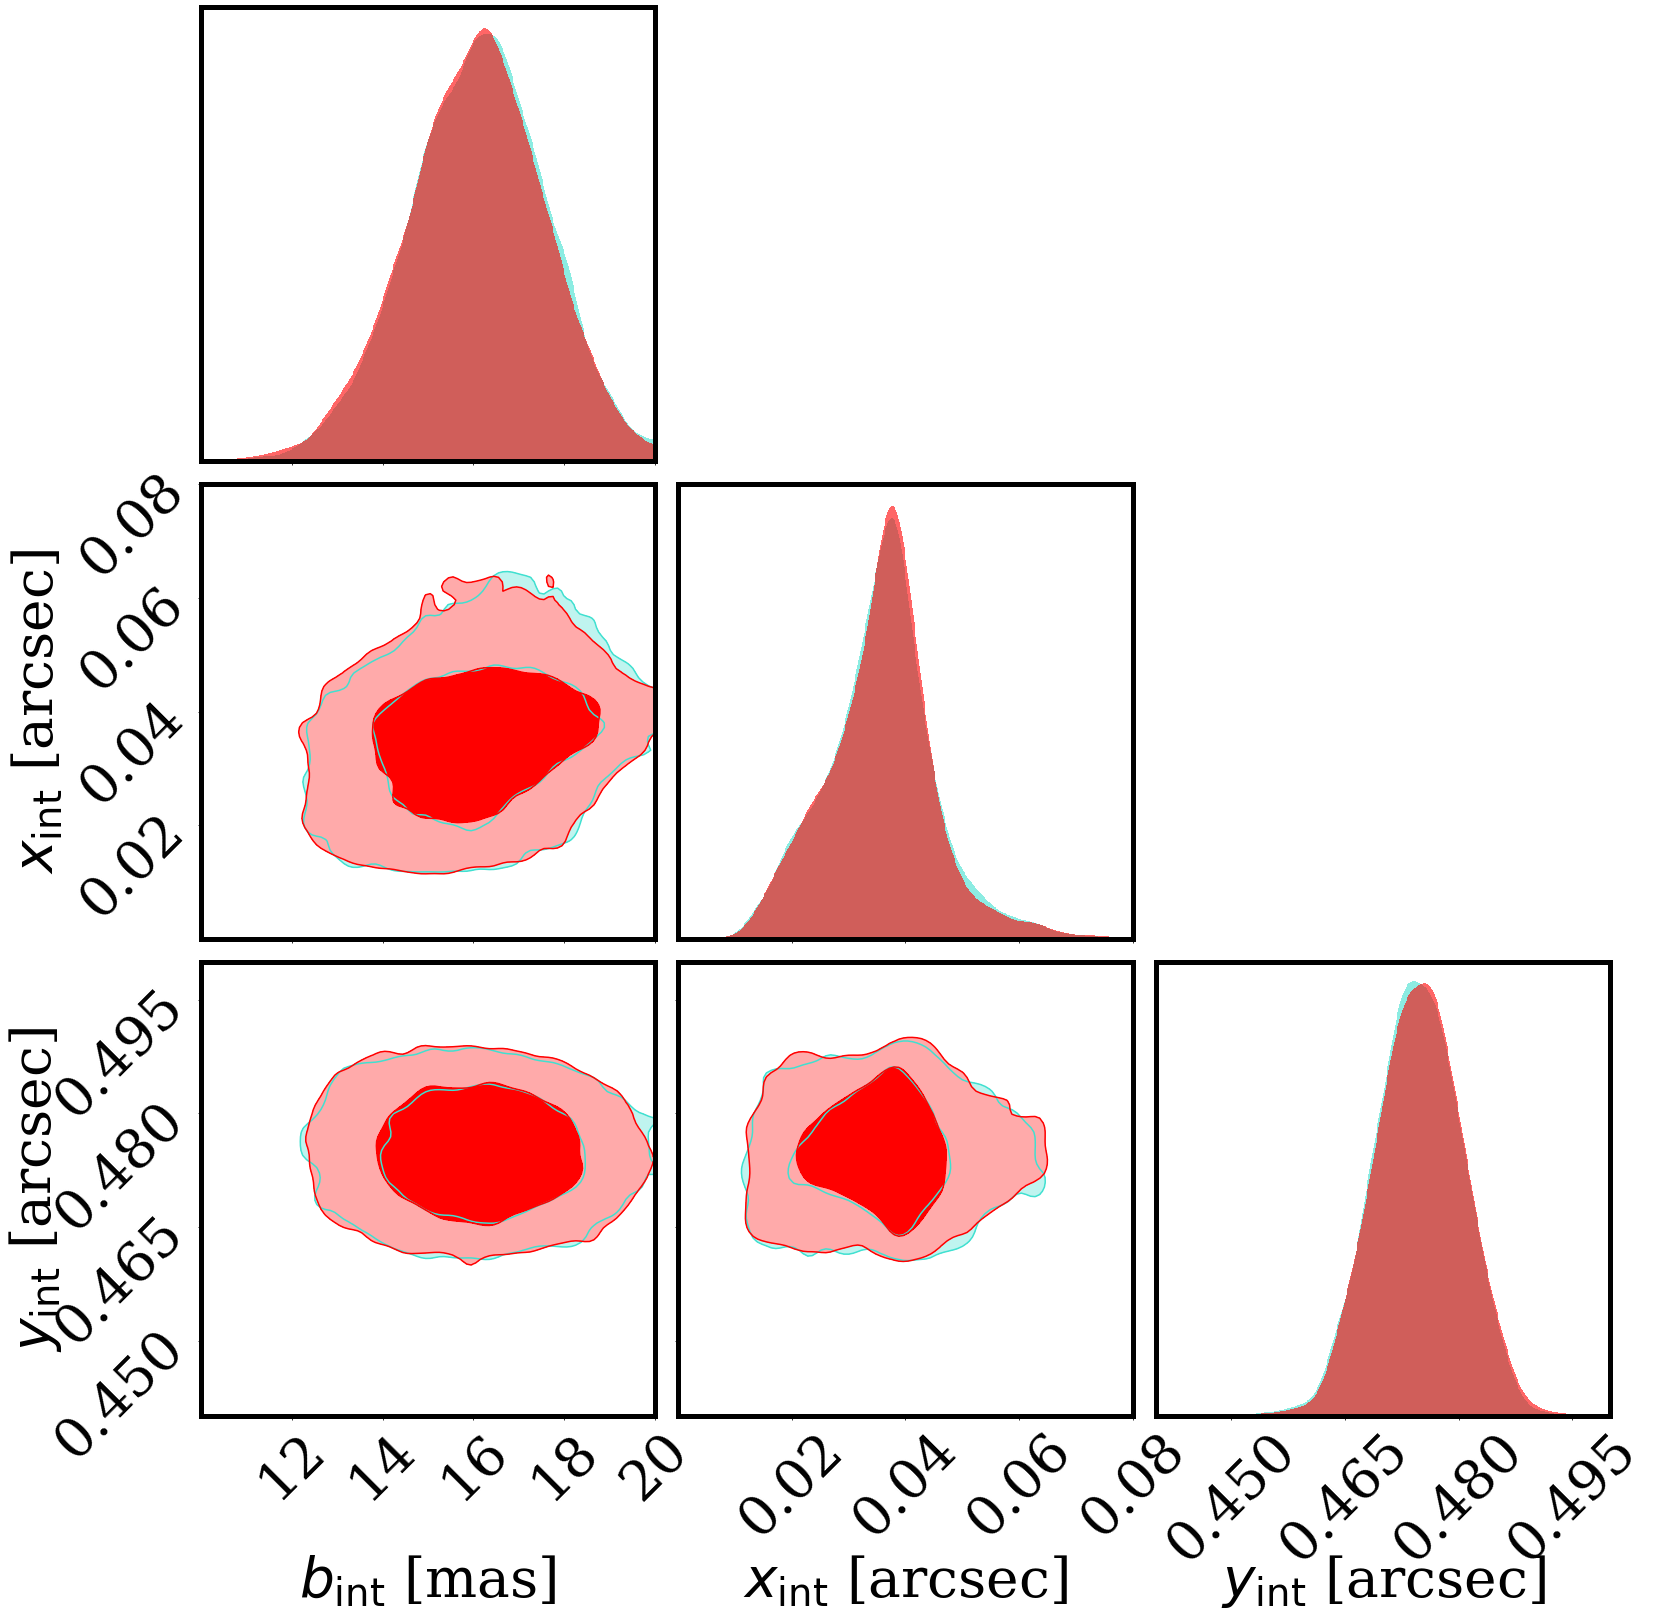

In [24]:
N = 3

fig = plt.subplots(N,N,figsize=(8*N,8*N))

matplotlib.rcParams['axes.linewidth'] = 2.0 #set the value globally

span = [[10,20.],[0.0,0.08],[0.44,0.50]]

quant = [0.6826894921370859,0.9544997361036416]

tfig2, taxes2 = dyplot.cornerplot(subjs[5],span=span,dims=np.arange(8,11),quantiles=[],quantiles_2d=quant,show_titles=False,truth_color='turquoise',labels=labls_mask_sub[8:11],color='turquoise',fig=fig)
tfig2, taxes2 = dyplot.cornerplot(subjwide10,span=span,dims=np.arange(8,11),quantiles=[],quantiles_2d=quant,show_titles=False,truth_color='red',labels=labls_mask_sub[8:11],color='red',fig=fig)